In [3]:
# numpy and pandas for data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier

sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# In this challenge, participants are to build a model trained on a historical demand dataset, that can forecast demand on a Hold-out test dataset. 

# The model should be able to accurately forecast ahead by T+1 to T+5 time intervals (where each interval is 15-min) given all data up to time T.

## Traffic Management

How may we improve the traffic congestion for Southeast Asia's roads by leveraging Grab's booking demand data?

This is a data science assignment where you are expected to create a data model from a given training dataset.

## PROBLEM STATEMENT

Economies in Southeast Asia are turning to AI to solve traffic congestion, which hinders mobility and economic growth. The first step in the push towards alleviating traffic congestion is to understand travel demand and travel patterns within the city.

Can we accurately forecast travel demand based on historical Grab bookings to predict areas and times with high travel demand?

In this challenge, participants are to build a model trained on a historical demand dataset, that can forecast demand on a Hold-out test dataset. The model should be able to accurately forecast ahead by T+1 to T+5 time intervals (where each interval is 15-min) given all data up to time T.

You are expected to create a Data Model based on the "Demand Data" dataset in order to solve the given problem statement.

You should also provide step by step documentation on how to run your code. Our evaluators will be running your data models on a test dataset.

The given dataset contains normalised historical demand of a city, aggregated spatiotemporally within geohashes and over 15 minute intervals. The dataset spans over a two month period. A brief description of the dataset fields are found below:

## Data Description

geohash6 - Geohash is a public domain geocoding system which encodes a geographic location into a short string of letters and digits with arbitrary precision. You are free to use any geohash library to encode/decode the geohashes into latitude and longitude or vice versa. Some examples include https://github.com/hkwi/python-geohash (for Python), https://github.com/kungfoo/geohash-java (for Java).

day - where the value indicates the sequential order and not a particular day of the month

timestamp - start time of 15-minute intervals, in the following format: <hour>:<minute>, where hour ranges from 0 to 23 and minute is either one of (0, 15, 30, 45)

demand - aggregated demand normalised to be in the range [0,1]

## You will be judged on the following criteria:


Code Quality, also known as Software Quality, is generally defined in two ways:
 
- How well does the code conform to the functional specifications and requirements 
of a project.

- Structural quality, which relates to the maintainability and robustness of the code.

Creativity in Problem-solving

- Creativity speaks volumes about your capability to make sense of given data, derive tangible results relevant to the business needs of an organization and present the findings. All this, while keeping in mind the problem statements. 
    
Check out our thought process behind these challenges in our short film! https://youtu.be/7BL8EeAkNDw?t=62

Feature Engineering

- also referred to as pre-processing, refers to the process of selecting and transforming variables when creating a data model for a given problem statement. While you will be given a general dataset which relates to the problem statement, you need to create “features” that make the models and algorithms work as intended.

- Note that your code should be able to automatically create your desired features, that can be used in the evaluation of the Hold-out test set.

Model Performance

- Model performance determines how a model represents the data and how well the chosen model will work. In this challenge, we will be performing a Hold-out model evaluation. For this problem, you are given a training dataset, and our evaluators will have a test dataset (not seen by the model). This test dataset will assess the likely future performance of the model.
 
## Test dataset details:

1. Timeframe: The test dataset can start from any time period after the timeframe of the training dataset. Your model can use features of up to 14 consecutive days from the test dataset, ending at timestamp T and predict T+1 to T+5.


2. Geohash coverage: You may assume that the set of geohashes are the same in training dataset and test dataset. The original geohashes are anonymised, but you may **assume that adjacency is maintained between the geohashes**.


Submissions will be evaluated by RMSE (root mean squared error) averaged over all geohash6, 15-minute-bucket pairs.

In [4]:
grab_train = pd.read_csv('./training.csv')

In [5]:
grab_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4206321 entries, 0 to 4206320
Data columns (total 4 columns):
geohash6     object
day          int64
timestamp    object
demand       float64
dtypes: float64(1), int64(1), object(2)
memory usage: 128.4+ MB


In [6]:
grab_train.describe()

day        demand
count  4.206321e+06  4.206321e+06
mean   3.145299e+01  1.050907e-01
std    1.768278e+01  1.592655e-01
min    1.000000e+00  3.092217e-09
25%    1.600000e+01  1.867379e-02
50%    3.200000e+01  5.043463e-02
75%    4.700000e+01  1.208644e-01
max    6.100000e+01  1.000000e+00

In [7]:
grab_train.isnull().sum() 

geohash6     0
day          0
timestamp    0
demand       0
dtype: int64

In [8]:
grab_train.shape

(4206321, 4)

In [9]:
grab_train.head(10)

geohash6  day timestamp    demand
0   qp03wc   18      20:0  0.020072
1   qp03pn   10     14:30  0.024721
2   qp09sw    9      6:15  0.102821
3   qp0991   32       5:0  0.088755
4   qp090q   15       4:0  0.074468
5   qp03tu    1     12:15  0.023843
6   qp096d   25      3:30  0.007460
7   qp03nr   51     20:45  0.000293
8   qp093r   48      6:15  0.054170
9   qp03r2    4     22:15  0.123463

In [10]:
grab_train.geohash6.nunique()

1329

In [11]:
grab_train.day.nunique()

61

## Code by Hiroaki Kawai to decode geohash

In [12]:
"""
Copyright (C) 2009 Hiroaki Kawai <kawai@iij.ad.jp>
"""
try:
	import _geohash
except ImportError:
	_geohash = None

__version__ = "0.8.5"
__all__ = ['encode','decode','decode_exactly','bbox', 'neighbors', 'expand']

_base32 = '0123456789bcdefghjkmnpqrstuvwxyz'
_base32_map = {}
for i in range(len(_base32)):
	_base32_map[_base32[i]] = i
del i

LONG_ZERO = 0
import sys
if sys.version_info[0] < 3:
	LONG_ZERO = long(0)

def _float_hex_to_int(f):
	if f<-1.0 or f>=1.0:
		return None
	
	if f==0.0:
		return 1,1
	
	h = f.hex()
	x = h.find("0x1.")
	assert(x>=0)
	p = h.find("p")
	assert(p>0)
	
	half_len = len(h[x+4:p])*4-int(h[p+1:])
	if x==0:
		r = (1<<half_len) + ((1<<(len(h[x+4:p])*4)) + int(h[x+4:p],16))
	else:
		r = (1<<half_len) - ((1<<(len(h[x+4:p])*4)) + int(h[x+4:p],16))
	
	return r, half_len+1

def _int_to_float_hex(i, l):
	if l==0:
		return -1.0
	
	half = 1<<(l-1)
	s = int((l+3)/4)
	if i >= half:
		i = i-half
		return float.fromhex(("0x0.%0"+str(s)+"xp1") % (i<<(s*4-l),))
	else:
		i = half-i
		return float.fromhex(("-0x0.%0"+str(s)+"xp1") % (i<<(s*4-l),))

def _encode_i2c(lat,lon,lat_length,lon_length):
	precision = int((lat_length+lon_length)/5)
	if lat_length < lon_length:
		a = lon
		b = lat
	else:
		a = lat
		b = lon
	
	boost = (0,1,4,5,16,17,20,21)
	ret = ''
	for i in range(precision):
		ret+=_base32[(boost[a&7]+(boost[b&3]<<1))&0x1F]
		t = a>>3
		a = b>>2
		b = t
	
	return ret[::-1]

def encode(latitude, longitude, precision=12):
	if latitude >= 90.0 or latitude < -90.0:
		raise Exception("invalid latitude.")
	while longitude < -180.0:
		longitude += 360.0
	while longitude >= 180.0:
		longitude -= 360.0
	
	if _geohash:
		basecode=_geohash.encode(latitude,longitude)
		if len(basecode)>precision:
			return basecode[0:precision]
		return basecode+'0'*(precision-len(basecode))
	
	xprecision=precision+1
	lat_length = lon_length = int(xprecision*5/2)
	if xprecision%2==1:
		lon_length+=1
	
	if hasattr(float, "fromhex"):
		a = _float_hex_to_int(latitude/90.0)
		o = _float_hex_to_int(longitude/180.0)
		if a[1] > lat_length:
			ai = a[0]>>(a[1]-lat_length)
		else:
			ai = a[0]<<(lat_length-a[1])
		
		if o[1] > lon_length:
			oi = o[0]>>(o[1]-lon_length)
		else:
			oi = o[0]<<(lon_length-o[1])
		
		return _encode_i2c(ai, oi, lat_length, lon_length)[:precision]
	
	lat = latitude/180.0
	lon = longitude/360.0
	
	if lat>0:
		lat = int((1<<lat_length)*lat)+(1<<(lat_length-1))
	else:
		lat = (1<<lat_length-1)-int((1<<lat_length)*(-lat))
	
	if lon>0:
		lon = int((1<<lon_length)*lon)+(1<<(lon_length-1))
	else:
		lon = (1<<lon_length-1)-int((1<<lon_length)*(-lon))
	
	return _encode_i2c(lat,lon,lat_length,lon_length)[:precision]

def _decode_c2i(hashcode):
	lon = 0
	lat = 0
	bit_length = 0
	lat_length = 0
	lon_length = 0
	for i in hashcode:
		t = _base32_map[i]
		if bit_length%2==0:
			lon = lon<<3
			lat = lat<<2
			lon += (t>>2)&4
			lat += (t>>2)&2
			lon += (t>>1)&2
			lat += (t>>1)&1
			lon += t&1
			lon_length+=3
			lat_length+=2
		else:
			lon = lon<<2
			lat = lat<<3
			lat += (t>>2)&4
			lon += (t>>2)&2
			lat += (t>>1)&2
			lon += (t>>1)&1
			lat += t&1
			lon_length+=2
			lat_length+=3
		
		bit_length+=5
	
	return (lat,lon,lat_length,lon_length)

def decode(hashcode, delta=False):
	'''
	decode a hashcode and get center coordinate, and distance between center and outer border
	'''
	if _geohash:
		(lat,lon,lat_bits,lon_bits) = _geohash.decode(hashcode)
		latitude_delta = 90.0/(1<<lat_bits)
		longitude_delta = 180.0/(1<<lon_bits)
		latitude = lat + latitude_delta
		longitude = lon + longitude_delta
		if delta:
			return latitude,longitude,latitude_delta,longitude_delta
		return latitude,longitude
	
	(lat,lon,lat_length,lon_length) = _decode_c2i(hashcode)
	
	if hasattr(float, "fromhex"):
		latitude_delta  = 90.0/(1<<lat_length)
		longitude_delta = 180.0/(1<<lon_length)
		latitude = _int_to_float_hex(lat, lat_length) * 90.0 + latitude_delta
		longitude = _int_to_float_hex(lon, lon_length) * 180.0 + longitude_delta
		if delta:
			return latitude,longitude,latitude_delta,longitude_delta
		return latitude,longitude
	
	lat = (lat<<1) + 1
	lon = (lon<<1) + 1
	lat_length += 1
	lon_length += 1
	
	latitude  = 180.0*(lat-(1<<(lat_length-1)))/(1<<lat_length)
	longitude = 360.0*(lon-(1<<(lon_length-1)))/(1<<lon_length)
	if delta:
		latitude_delta  = 180.0/(1<<lat_length)
		longitude_delta = 360.0/(1<<lon_length)
		return latitude,longitude,latitude_delta,longitude_delta
	
	return latitude,longitude

def decode_exactly(hashcode):
	return decode(hashcode, True)

## hashcode operations below

def bbox(hashcode):
	'''
	decode a hashcode and get north, south, east and west border.
	'''
	if _geohash:
		(lat,lon,lat_bits,lon_bits) = _geohash.decode(hashcode)
		latitude_delta = 180.0/(1<<lat_bits)
		longitude_delta = 360.0/(1<<lon_bits)
		return {'s':lat,'w':lon,'n':lat+latitude_delta,'e':lon+longitude_delta}
	
	(lat,lon,lat_length,lon_length) = _decode_c2i(hashcode)
	if hasattr(float, "fromhex"):
		latitude_delta  = 180.0/(1<<lat_length)
		longitude_delta = 360.0/(1<<lon_length)
		latitude = _int_to_float_hex(lat, lat_length) * 90.0
		longitude = _int_to_float_hex(lon, lon_length) * 180.0
		return {"s":latitude, "w":longitude, "n":latitude+latitude_delta, "e":longitude+longitude_delta}
	
	ret={}
	if lat_length:
		ret['n'] = 180.0*(lat+1-(1<<(lat_length-1)))/(1<<lat_length)
		ret['s'] = 180.0*(lat-(1<<(lat_length-1)))/(1<<lat_length)
	else: # can't calculate the half with bit shifts (negative shift)
		ret['n'] = 90.0
		ret['s'] = -90.0
	
	if lon_length:
		ret['e'] = 360.0*(lon+1-(1<<(lon_length-1)))/(1<<lon_length)
		ret['w'] = 360.0*(lon-(1<<(lon_length-1)))/(1<<lon_length)
	else: # can't calculate the half with bit shifts (negative shift)
		ret['e'] = 180.0
		ret['w'] = -180.0
	
	return ret

def neighbors(hashcode):
	if _geohash and len(hashcode)<25:
		return _geohash.neighbors(hashcode)
	
	(lat,lon,lat_length,lon_length) = _decode_c2i(hashcode)
	ret = []
	tlat = lat
	for tlon in (lon-1, lon+1):
		code = _encode_i2c(tlat,tlon,lat_length,lon_length)
		if code:
			ret.append(code)
	
	tlat = lat+1
	if not tlat >> lat_length:
		for tlon in (lon-1, lon, lon+1):
			ret.append(_encode_i2c(tlat,tlon,lat_length,lon_length))
	
	tlat = lat-1
	if tlat >= 0:
		for tlon in (lon-1, lon, lon+1):
			ret.append(_encode_i2c(tlat,tlon,lat_length,lon_length))
	
	return ret

def expand(hashcode):
	ret = neighbors(hashcode)
	ret.append(hashcode)
	return ret

def _uint64_interleave(lat32, lon32):
	intr = 0
	boost = (0,1,4,5,16,17,20,21,64,65,68,69,80,81,84,85)
	for i in range(8):
		intr = (intr<<8) + (boost[(lon32>>(28-i*4))%16]<<1) + boost[(lat32>>(28-i*4))%16]
	
	return intr

def _uint64_deinterleave(ui64):
	lat = lon = 0
	boost = ((0,0),(0,1),(1,0),(1,1),(0,2),(0,3),(1,2),(1,3),
			 (2,0),(2,1),(3,0),(3,1),(2,2),(2,3),(3,2),(3,3))
	for i in range(16):
		p = boost[(ui64>>(60-i*4))%16]
		lon = (lon<<2) + p[0]
		lat = (lat<<2) + p[1]
	
	return (lat, lon)

def encode_uint64(latitude, longitude):
	if latitude >= 90.0 or latitude < -90.0:
		raise ValueError("Latitude must be in the range of (-90.0, 90.0)")
	while longitude < -180.0:
		longitude += 360.0
	while longitude >= 180.0:
		longitude -= 360.0
	
	if _geohash:
		ui128 = _geohash.encode_int(latitude,longitude)
		if _geohash.intunit == 64:
			return ui128[0]
		elif _geohash.intunit == 32:
			return (ui128[0]<<32) + ui128[1]
		elif _geohash.intunit == 16:
			return (ui128[0]<<48) + (ui128[1]<<32) + (ui128[2]<<16) + ui128[3]
	
	lat = int(((latitude + 90.0)/180.0)*(1<<32))
	lon = int(((longitude+180.0)/360.0)*(1<<32))
	return _uint64_interleave(lat, lon)

def decode_uint64(ui64):
	if _geohash:
		latlon = _geohash.decode_int(ui64 % 0xFFFFFFFFFFFFFFFF, LONG_ZERO)
		if latlon:
			return latlon
	
	lat,lon = _uint64_deinterleave(ui64)
	return (180.0*lat/(1<<32) - 90.0, 360.0*lon/(1<<32) - 180.0)

def expand_uint64(ui64, precision=50):
	ui64 = ui64 & (0xFFFFFFFFFFFFFFFF << (64-precision))
	lat,lon = _uint64_deinterleave(ui64)
	lat_grid = 1<<(32-int(precision/2))
	lon_grid = lat_grid>>(precision%2)
	
	if precision<=2: # expand becomes to the whole range
		return []
	
	ranges = []
	if lat & lat_grid:
		if lon & lon_grid:
			ui64 = _uint64_interleave(lat-lat_grid, lon-lon_grid)
			ranges.append((ui64, ui64 + (1<<(64-precision+2))))
			if precision%2==0:
				# lat,lon = (1, 1) and even precision
				ui64 = _uint64_interleave(lat-lat_grid, lon+lon_grid)
				ranges.append((ui64, ui64 + (1<<(64-precision+1))))
				
				if lat + lat_grid < 0xFFFFFFFF:
					ui64 = _uint64_interleave(lat+lat_grid, lon-lon_grid)
					ranges.append((ui64, ui64 + (1<<(64-precision))))
					ui64 = _uint64_interleave(lat+lat_grid, lon)
					ranges.append((ui64, ui64 + (1<<(64-precision))))
					ui64 = _uint64_interleave(lat+lat_grid, lon+lon_grid)
					ranges.append((ui64, ui64 + (1<<(64-precision))))
			else:
				# lat,lon = (1, 1) and odd precision
				if lat + lat_grid < 0xFFFFFFFF:
					ui64 = _uint64_interleave(lat+lat_grid, lon-lon_grid)
					ranges.append((ui64, ui64 + (1<<(64-precision+1))))
					
					ui64 = _uint64_interleave(lat+lat_grid, lon+lon_grid)
					ranges.append((ui64, ui64 + (1<<(64-precision))))
				
				ui64 = _uint64_interleave(lat, lon+lon_grid)
				ranges.append((ui64, ui64 + (1<<(64-precision))))
				ui64 = _uint64_interleave(lat-lat_grid, lon+lon_grid)
				ranges.append((ui64, ui64 + (1<<(64-precision))))
		else:
			ui64 = _uint64_interleave(lat-lat_grid, lon)
			ranges.append((ui64, ui64 + (1<<(64-precision+2))))
			if precision%2==0:
				# lat,lon = (1, 0) and odd precision
				ui64 = _uint64_interleave(lat-lat_grid, lon-lon_grid)
				ranges.append((ui64, ui64 + (1<<(64-precision+1))))
				
				if lat + lat_grid < 0xFFFFFFFF:
					ui64 = _uint64_interleave(lat+lat_grid, lon-lon_grid)
					ranges.append((ui64, ui64 + (1<<(64-precision))))
					ui64 = _uint64_interleave(lat+lat_grid, lon)
					ranges.append((ui64, ui64 + (1<<(64-precision))))
					ui64 = _uint64_interleave(lat+lat_grid, lon+lon_grid)
					ranges.append((ui64, ui64 + (1<<(64-precision))))
			else:
				# lat,lon = (1, 0) and odd precision
				if lat + lat_grid < 0xFFFFFFFF:
					ui64 = _uint64_interleave(lat+lat_grid, lon)
					ranges.append((ui64, ui64 + (1<<(64-precision+1))))
					
					ui64 = _uint64_interleave(lat+lat_grid, lon-lon_grid)
					ranges.append((ui64, ui64 + (1<<(64-precision))))
				ui64 = _uint64_interleave(lat, lon-lon_grid)
				ranges.append((ui64, ui64 + (1<<(64-precision))))
				ui64 = _uint64_interleave(lat-lat_grid, lon-lon_grid)
				ranges.append((ui64, ui64 + (1<<(64-precision))))
	else:
		if lon & lon_grid:
			ui64 = _uint64_interleave(lat, lon-lon_grid)
			ranges.append((ui64, ui64 + (1<<(64-precision+2))))
			if precision%2==0:
				# lat,lon = (0, 1) and even precision
				ui64 = _uint64_interleave(lat, lon+lon_grid)
				ranges.append((ui64, ui64 + (1<<(64-precision+1))))
				
				if lat > 0:
					ui64 = _uint64_interleave(lat-lat_grid, lon-lon_grid)
					ranges.append((ui64, ui64 + (1<<(64-precision))))
					ui64 = _uint64_interleave(lat-lat_grid, lon)
					ranges.append((ui64, ui64 + (1<<(64-precision))))
					ui64 = _uint64_interleave(lat-lat_grid, lon+lon_grid)
					ranges.append((ui64, ui64 + (1<<(64-precision))))
			else:
				# lat,lon = (0, 1) and odd precision
				if lat > 0:
					ui64 = _uint64_interleave(lat-lat_grid, lon-lon_grid)
					ranges.append((ui64, ui64 + (1<<(64-precision+1))))
					
					ui64 = _uint64_interleave(lat-lat_grid, lon+lon_grid)
					ranges.append((ui64, ui64 + (1<<(64-precision))))
				ui64 = _uint64_interleave(lat, lon+lon_grid)
				ranges.append((ui64, ui64 + (1<<(64-precision))))
				ui64 = _uint64_interleave(lat+lat_grid, lon+lon_grid)
				ranges.append((ui64, ui64 + (1<<(64-precision))))
		else:
			ui64 = _uint64_interleave(lat, lon)
			ranges.append((ui64, ui64 + (1<<(64-precision+2))))
			if precision%2==0:
				# lat,lon = (0, 0) and even precision
				ui64 = _uint64_interleave(lat, lon-lon_grid)
				ranges.append((ui64, ui64 + (1<<(64-precision+1))))
				
				if lat > 0:
					ui64 = _uint64_interleave(lat-lat_grid, lon-lon_grid)
					ranges.append((ui64, ui64 + (1<<(64-precision))))
					ui64 = _uint64_interleave(lat-lat_grid, lon)
					ranges.append((ui64, ui64 + (1<<(64-precision))))
					ui64 = _uint64_interleave(lat-lat_grid, lon+lon_grid)
					ranges.append((ui64, ui64 + (1<<(64-precision))))
			else:
				# lat,lon = (0, 0) and odd precision
				if lat > 0:
					ui64 = _uint64_interleave(lat-lat_grid, lon)
					ranges.append((ui64, ui64 + (1<<(64-precision+1))))
					
					ui64 = _uint64_interleave(lat-lat_grid, lon-lon_grid)
					ranges.append((ui64, ui64 + (1<<(64-precision))))
				ui64 = _uint64_interleave(lat, lon-lon_grid)
				ranges.append((ui64, ui64 + (1<<(64-precision))))
				ui64 = _uint64_interleave(lat+lat_grid, lon-lon_grid)
				ranges.append((ui64, ui64 + (1<<(64-precision))))
	
	ranges.sort()
	
	# merge the conditions
	shrink = []
	prev = None
	for i in ranges:
		if prev:
			if prev[1] != i[0]:
				shrink.append(prev)
				prev = i
			else:
				prev = (prev[0], i[1])
		else:
			prev = i
	
	shrink.append(prev)
	
	ranges = []
	for i in shrink:
		a,b=i
		if a == 0:
			a = None # we can remove the condition because it is the lowest value
		if b == 0x10000000000000000:
			b = None # we can remove the condition because it is the highest value
		
		ranges.append((a,b))
	
	return ranges

### Explore the different functions to see what it brings us

In [13]:
expand('qp03wc')

['qp03w9',
 'qp03x1',
 'qp03wd',
 'qp03wf',
 'qp03x4',
 'qp03w8',
 'qp03wb',
 'qp03x0',
 'qp03wc']

In [14]:
neighbors('qp03wc')

['qp03w9',
 'qp03x1',
 'qp03wd',
 'qp03wf',
 'qp03x4',
 'qp03w8',
 'qp03wb',
 'qp03x0']

In [15]:
decode('qp03wc', delta=False)

(-5.35308837890625, 90.6536865234375)

In [16]:
bbox('qp03wc')

{'s': -5.3558349609375,
 'w': 90.648193359375,
 'n': -5.350341796875,
 'e': 90.6591796875}

In [17]:
_decode_c2i('qp03wc')

(15409, 24635, 15, 15)

### We will be using decode function to give us lat and lon

In [18]:
geohash_latdict = {}
geohash_londict = {}

for i in grab_train['geohash6'].unique():
    lat_long = decode(i)
    latitude = float(lat_long[0])
    longtitude = float(lat_long[1])
    geohash_latdict.update({i:latitude})
    geohash_londict.update({i:longtitude})
    
grab_train['latitude'] = grab_train['geohash6'].map(geohash_latdict)
grab_train['longitude'] = grab_train['geohash6'].map(geohash_londict)

In [19]:
grab_train.shape

(4206321, 6)

In [20]:
grab_train['geohash6'].nunique()

1329

In [21]:
grab_train = grab_train.sort_values(by=['geohash6','day','timestamp'])

In [25]:
grab_train.head(5)

geohash6  day timestamp    demand  latitude  longitude
2021861   qp02yc    1     11:15  0.013487 -5.484924  90.653687
1403484   qp02yc    1      12:0  0.003709 -5.484924  90.653687
2873712   qp02yc    1      2:45  0.020592 -5.484924  90.653687
2643238   qp02yc    1       3:0  0.010292 -5.484924  90.653687
1791986   qp02yc    1       4:0  0.006676 -5.484924  90.653687

In [26]:
grab_train.tail(5)

geohash6  day timestamp    demand  latitude  longitude
2913817   qp0dnn   60     10:45  0.001280 -5.237732   90.97229
2564539   qp0dnn   60      11:0  0.045466 -5.237732   90.97229
988269    qp0dnn   60     11:15  0.029285 -5.237732   90.97229
1896685   qp0dnn   60      1:30  0.003741 -5.237732   90.97229
2110513   qp0dnn   61       9:0  0.000896 -5.237732   90.97229

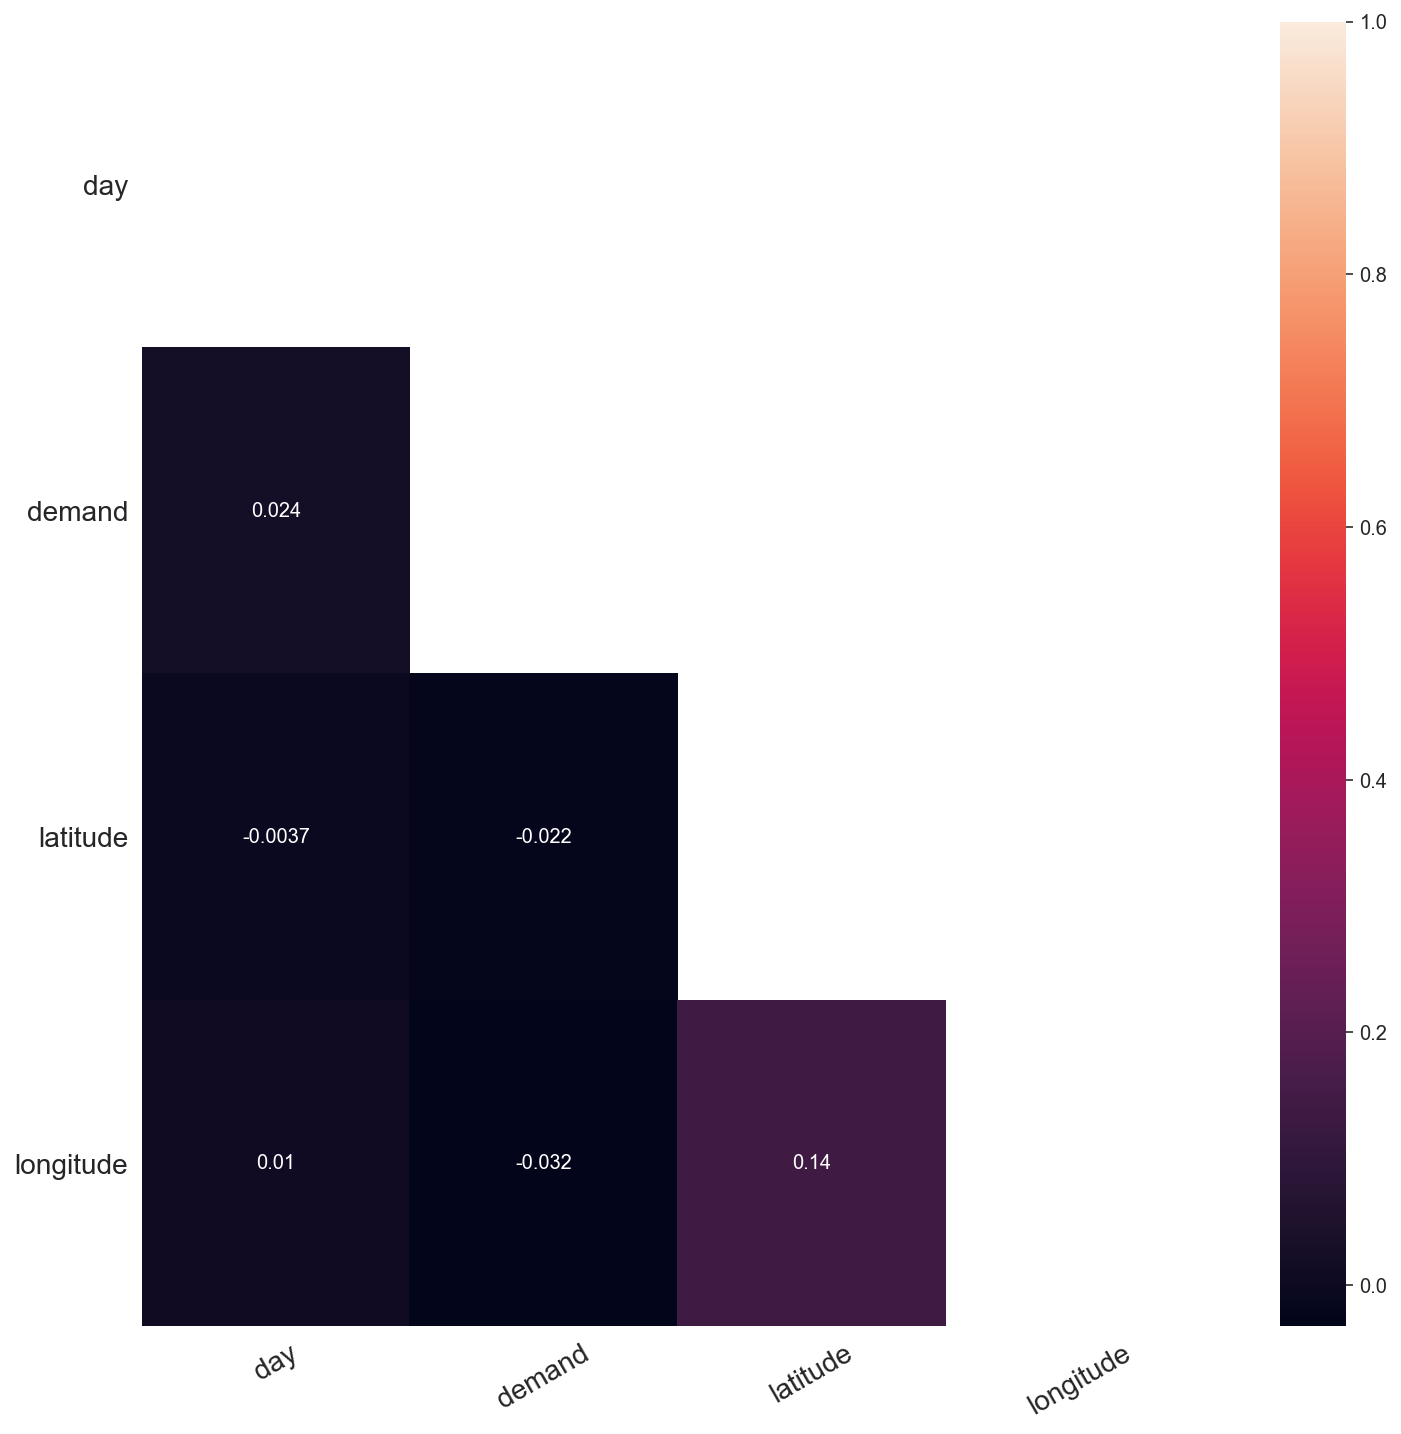

In [97]:
def correlation_heat_map(df): 
    corrs = df.corr() 

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(12,12)) 

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool) 
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.    
    ax = sns.heatmap(corrs, mask=mask, annot=True)

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()

correlation_heat_map(grab_train)


In [100]:
import folium
from folium.plugins import HeatMap

def generateBaseMap(default_location=[-5.3, 90.83687], default_zoom_start=5):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

base_map = generateBaseMap()
HeatMap(data=grab_train[['latitude', 'longitude', 'demand']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
base_map

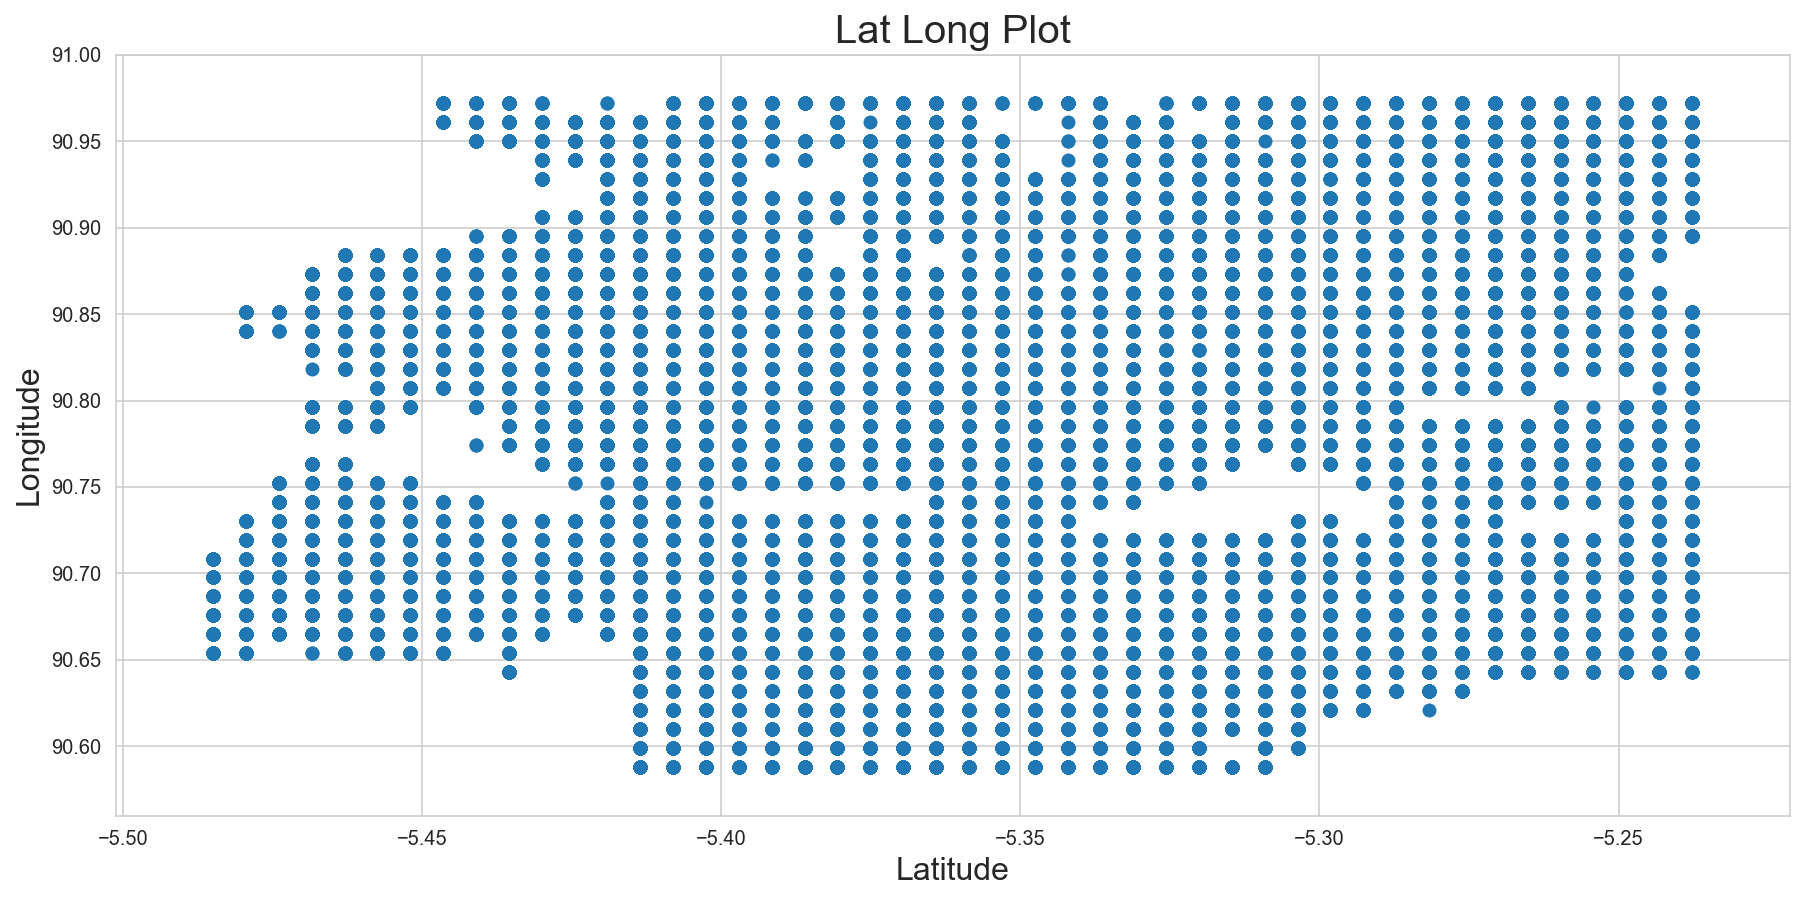

In [101]:
plt.figure(figsize=(15,7))
plt.scatter(x=grab_train['latitude'],y=grab_train['longitude'])
plt.title('Lat Long Plot', fontsize=20)
plt.xlabel('Latitude', fontsize=16)
plt.ylabel('Longitude', fontsize=16)
plt.show()

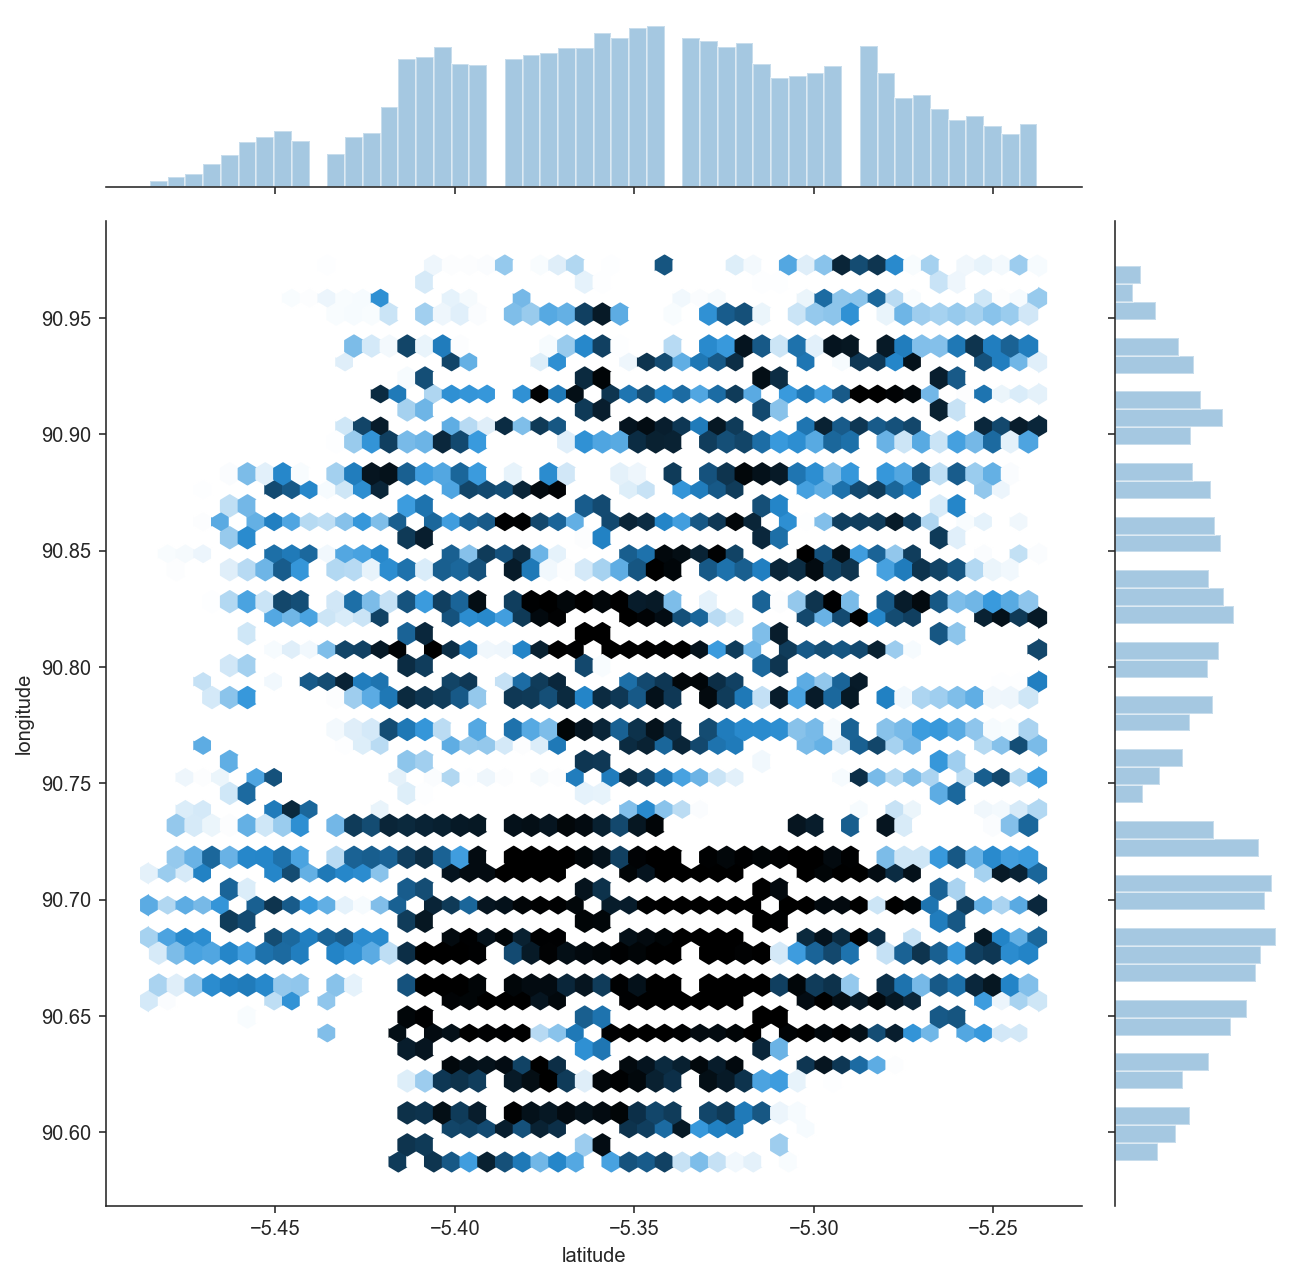

In [107]:
sns.jointplot(x=grab_train['latitude'],y=grab_train['longitude'],height=9,kind='hex')
plt.show()

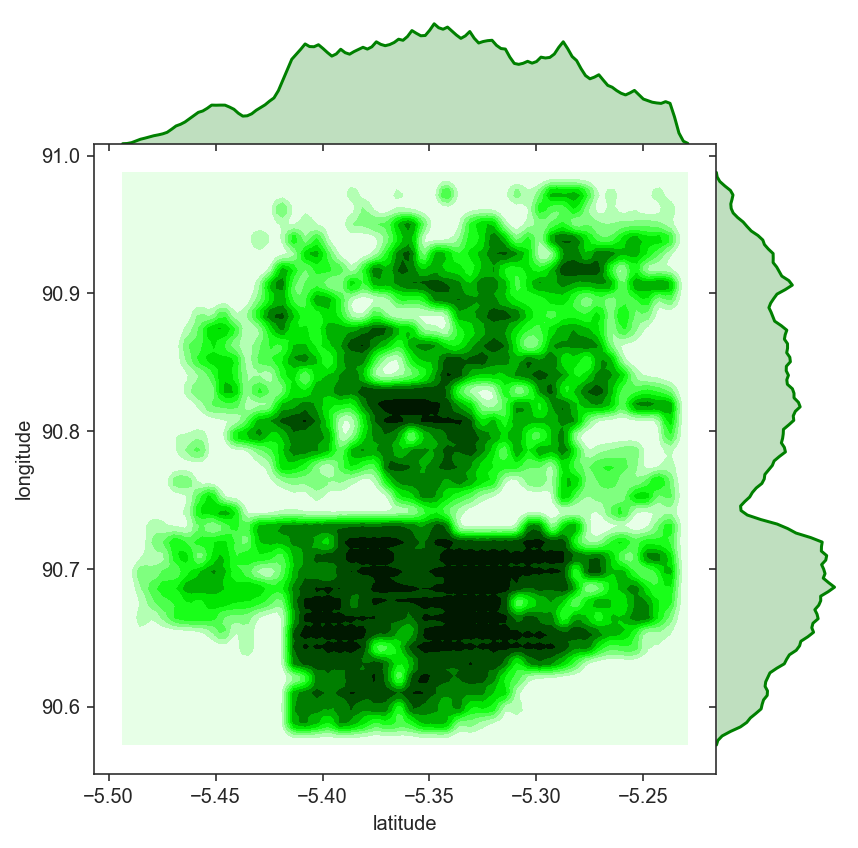

In [108]:
sns.jointplot(x=grab_train['latitude'],y=grab_train['longitude'],kind="kde", space=0, color="g")
#Note: this takes quite awhile to run.

In [27]:
grab_train = grab_train.sort_values(by=['timestamp'])

In [28]:
grab_train.head()

geohash6  day timestamp    demand  latitude  longitude
3849049   qp093q   56       0:0  0.020689 -5.369568  90.763550
902676    qp09fw   40       0:0  0.008320 -5.281677  90.818481
1047754   qp092j   29       0:0  0.229908 -5.375061  90.708618
4107759   qp02zy   31       0:0  0.088888 -5.457458  90.697632
95122     qp09un   43       0:0  0.054890 -5.281677  90.884399

In [110]:
grab_train.tail()

geohash6  day  timestamp    demand  latitude  longitude
3367873   qp02zt   39       9.45  0.209239 -5.462952  90.686646
3047028   qp03wp    5       9.45  0.027779 -5.320129  90.620728
3047019   qp06ng   30       9.45  0.020810 -5.254211  90.653687
1278095   qp09q5   36       9.45  0.019034 -5.386047  90.972290
2096778   qp097s   15       9.45  0.632464 -5.380554  90.862427

In [43]:
grab_train.dtypes

geohash6      object
day            int64
timestamp     object
demand       float64
latitude     float64
longitude    float64
dtype: object

In [103]:
grab_train.timestamp.unique()

array(['0:0', '0:15', '0:30', '0:45', '10:0', '10:15', '10:30', '10:45',
       '11:0', '11:15', '11:30', '11:45', '12:0', '12:15', '12:30',
       '12:45', '13:0', '13:15', '13:30', '13:45', '14:0', '14:15',
       '14:30', '14:45', '15:0', '15:15', '15:30', '15:45', '16:0',
       '16:15', '16:30', '16:45', '17:0', '17:15', '17:30', '17:45',
       '18:0', '18:15', '18:30', '18:45', '19:0', '19:15', '19:30',
       '19:45', '1:0', '1:15', '1:30', '1:45', '20:0', '20:15', '20:30',
       '20:45', '21:0', '21:15', '21:30', '21:45', '22:0', '22:15',
       '22:30', '22:45', '23:0', '23:15', '23:30', '23:45', '2:0', '2:15',
       '2:30', '2:45', '3:0', '3:15', '3:30', '3:45', '4:0', '4:15',
       '4:30', '4:45', '5:0', '5:15', '5:30', '5:45', '6:0', '6:15',
       '6:30', '6:45', '7:0', '7:15', '7:30', '7:45', '8:0', '8:15',
       '8:30', '8:45', '9:0', '9:15', '9:30', '9:45'], dtype=object)

In [29]:
grab_time_sort = grab_train.copy()

In [30]:
grab_time_sort['timestamp'] = grab_time_sort['timestamp'].apply(lambda x: float(x.replace(':','.')))

In [31]:
grab_time_sort.dtypes

geohash6      object
day            int64
timestamp    float64
demand       float64
latitude     float64
longitude    float64
dtype: object

In [32]:
grab_time_sort = grab_time_sort.sort_values(by=['geohash6','day','timestamp'])

In [33]:
grab_time_sort.head(40)

geohash6  day  timestamp    demand  latitude  longitude
2873712   qp02yc    1       2.45  0.020592 -5.484924  90.653687
2643238   qp02yc    1       3.00  0.010292 -5.484924  90.653687
1791986   qp02yc    1       4.00  0.006676 -5.484924  90.653687
4022333   qp02yc    1       4.30  0.003822 -5.484924  90.653687
3848343   qp02yc    1       6.45  0.011131 -5.484924  90.653687
2021861   qp02yc    1      11.15  0.013487 -5.484924  90.653687
1403484   qp02yc    1      12.00  0.003709 -5.484924  90.653687
897330    qp02yc    2       4.30  0.011041 -5.484924  90.653687
4014082   qp02yc    2       5.00  0.040743 -5.484924  90.653687
2613081   qp02yc    2       8.45  0.026320 -5.484924  90.653687
1754613   qp02yc    2      12.00  0.006989 -5.484924  90.653687
886989    qp02yc    2      22.45  0.031419 -5.484924  90.653687
2319843   qp02yc    3       4.15  0.012687 -5.484924  90.653687
2378396   qp02yc    3       5.15  0.027531 -5.484924  90.653687
1185822   qp02yc    3       6.30  0.005432 -5.484924  90.653687
3433787   qp02yc    3       6.45  0.037369 -5.484924  90.653687
1131501   qp02yc    3       8.00  0.001456 -5.484924  90.653687
4051660   qp02yc    3       8.30  0.014042 -5.484924  90.653687
3588340   qp02yc    3       9.45  0.027179 -5.484924  90.653687
1674368   qp02yc    4       3.30  0.018839 -5.484924  90.653687
1295779   qp02yc    4       4.00  0.012716 -5.484924  90.653687
1336225   qp02yc    4       4.15  0.029508 -5.484924  90.653687
414668    qp02yc    4       4.30  0.057966 -5.484924  90.653687
3129611   qp02yc    4       5.00  0.032100 -5.484924  90.653687
1370043   qp02yc    4       5.15  0.021253 -5.484924  90.653687
592326    qp02yc    4       6.00  0.044834 -5.484924  90.653687
245777    qp02yc    4       6.30  0.007841 -5.484924  90.653687
207244    qp02yc    4      10.15  0.014625 -5.484924  90.653687
1877045   qp02yc    4      10.45  0.022054 -5.484924  90.653687
3572253   qp02yc    4      11.00  0.016541 -5.484924  90.653687
639251    qp02yc    4      11.30  0.007581 -5.484924  90.653687
279309    qp02yc    4      13.00  0.005394 -5.484924  90.653687
878479    qp02yc    5       5.00  0.004341 -5.484924  90.653687
3399175   qp02yc    5       7.00  0.045270 -5.484924  90.653687
753792    qp02yc    5       8.15  0.007418 -5.484924  90.653687
3513290   qp02yc    5      10.15  0.014174 -5.484924  90.653687
3557764   qp02yc    6      11.45  0.028558 -5.484924  90.653687
1651539   qp02yc    6      23.00  0.005460 -5.484924  90.653687
2160962   qp02yc    7       1.00  0.000190 -5.484924  90.653687
2122387   qp02yc    7       1.15  0.062896 -5.484924  90.653687

In [34]:
grab_time_sort.tail(40)

geohash6  day  timestamp    demand  latitude  longitude
646170    qp0dnn   42       7.45  0.009942 -5.237732   90.97229
128753    qp0dnn   42       8.00  0.004793 -5.237732   90.97229
2115546   qp0dnn   42       9.30  0.011146 -5.237732   90.97229
3597122   qp0dnn   42       9.45  0.000887 -5.237732   90.97229
3925611   qp0dnn   43       3.45  0.003057 -5.237732   90.97229
2067612   qp0dnn   43       8.15  0.003903 -5.237732   90.97229
4042205   qp0dnn   43       8.45  0.002382 -5.237732   90.97229
4154617   qp0dnn   43       9.00  0.004762 -5.237732   90.97229
2600112   qp0dnn   43       9.15  0.005888 -5.237732   90.97229
2524446   qp0dnn   46      15.15  0.001671 -5.237732   90.97229
1134175   qp0dnn   48       4.30  0.000738 -5.237732   90.97229
1256345   qp0dnn   48      19.45  0.007751 -5.237732   90.97229
4158551   qp0dnn   49      22.45  0.002617 -5.237732   90.97229
3462907   qp0dnn   49      23.00  0.004067 -5.237732   90.97229
3469170   qp0dnn   51      10.00  0.030558 -5.237732   90.97229
1375887   qp0dnn   52       7.30  0.002420 -5.237732   90.97229
2023048   qp0dnn   52      10.30  0.005091 -5.237732   90.97229
2232297   qp0dnn   54      13.00  0.004463 -5.237732   90.97229
3134720   qp0dnn   55      22.15  0.000550 -5.237732   90.97229
1754867   qp0dnn   56       9.15  0.015596 -5.237732   90.97229
3442116   qp0dnn   56       9.30  0.016088 -5.237732   90.97229
454615    qp0dnn   56      10.15  0.016509 -5.237732   90.97229
2070445   qp0dnn   56      10.30  0.005008 -5.237732   90.97229
3235647   qp0dnn   56      10.45  0.026476 -5.237732   90.97229
3842677   qp0dnn   56      11.15  0.015455 -5.237732   90.97229
1924623   qp0dnn   56      22.30  0.012714 -5.237732   90.97229
3811470   qp0dnn   57       9.15  0.000220 -5.237732   90.97229
3678995   qp0dnn   57       9.30  0.016268 -5.237732   90.97229
883595    qp0dnn   57      10.00  0.015804 -5.237732   90.97229
2068134   qp0dnn   57      10.15  0.006540 -5.237732   90.97229
3763207   qp0dnn   57      10.30  0.005616 -5.237732   90.97229
2329890   qp0dnn   59       2.00  0.002340 -5.237732   90.97229
2523853   qp0dnn   59       8.15  0.009144 -5.237732   90.97229
673156    qp0dnn   59       9.30  0.012543 -5.237732   90.97229
2202839   qp0dnn   59      10.30  0.017128 -5.237732   90.97229
1896685   qp0dnn   60       1.30  0.003741 -5.237732   90.97229
2913817   qp0dnn   60      10.45  0.001280 -5.237732   90.97229
2564539   qp0dnn   60      11.00  0.045466 -5.237732   90.97229
988269    qp0dnn   60      11.15  0.029285 -5.237732   90.97229
2110513   qp0dnn   61       9.00  0.000896 -5.237732   90.97229

In [106]:
grab_time_sort.timestamp.unique()

array([ 0.  ,  0.15,  0.3 ,  0.45, 10.  , 10.15, 10.3 , 10.45, 11.  ,
       11.15, 11.3 , 11.45, 12.  , 12.15, 12.3 , 12.45, 13.  , 13.15,
       13.3 , 13.45, 14.  , 14.15, 14.3 , 14.45, 15.  , 15.15, 15.3 ,
       15.45, 16.  , 16.15, 16.3 , 16.45, 17.  , 17.15, 17.3 , 17.45,
       18.  , 18.15, 18.3 , 18.45, 19.  , 19.15, 19.3 , 19.45,  1.  ,
        1.15,  1.3 ,  1.45, 20.  , 20.15, 20.3 , 20.45, 21.  , 21.15,
       21.3 , 21.45, 22.  , 22.15, 22.3 , 22.45, 23.  , 23.15, 23.3 ,
       23.45,  2.  ,  2.15,  2.3 ,  2.45,  3.  ,  3.15,  3.3 ,  3.45,
        4.  ,  4.15,  4.3 ,  4.45,  5.  ,  5.15,  5.3 ,  5.45,  6.  ,
        6.15,  6.3 ,  6.45,  7.  ,  7.15,  7.3 ,  7.45,  8.  ,  8.15,
        8.3 ,  8.45,  9.  ,  9.15,  9.3 ,  9.45])

In [107]:
grab_time_sort = grab_time_sort.sort_values(by=['timestamp'])

In [108]:
grab_time_sort.head()

geohash6  day  timestamp    demand  latitude  longitude
3849049   qp093q   56        0.0  0.020689 -5.369568  90.763550
399633    qp0949   60        0.0  0.023670 -5.440979  90.818481
2402827   qp03xw   27        0.0  0.202005 -5.325623  90.686646
2239555   qp09gk   40        0.0  0.091966 -5.292664  90.851440
2869733   qp0dhb   53        0.0  0.219203 -5.270691  90.917358

In [59]:
grab_time_sort.tail()

geohash6  day  timestamp    demand  latitude  longitude
506120    qp06p2   12      23.45  0.003441 -5.270691  90.675659
3890504   qp09en   21      23.45  0.003478 -5.325623  90.840454
3753215   qp06p2   11      23.45  0.055616 -5.270691  90.675659
2757692   qp099s   25      23.45  0.063768 -5.336609  90.774536
3892822   qp0djq   25      23.45  0.020200 -5.237732  90.939331

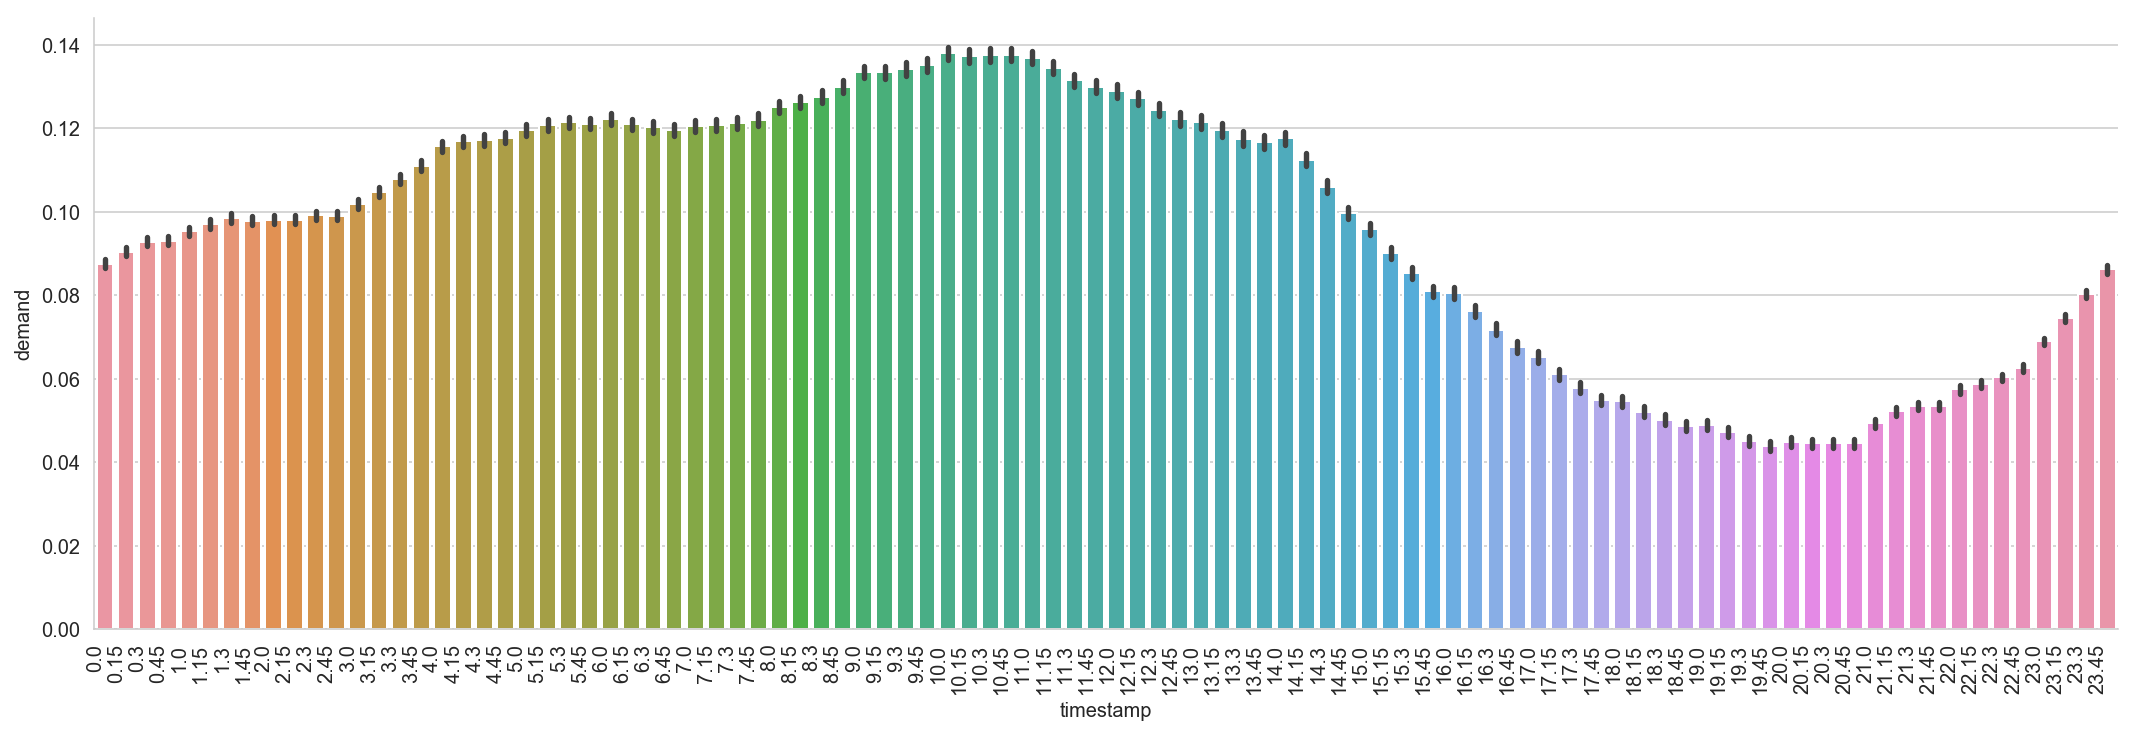

In [79]:
sns.catplot(x='timestamp', y='demand', 
               data=grab_time_sort, kind='bar', aspect=3).set_xticklabels(rotation=90, horizontalalignment='right')

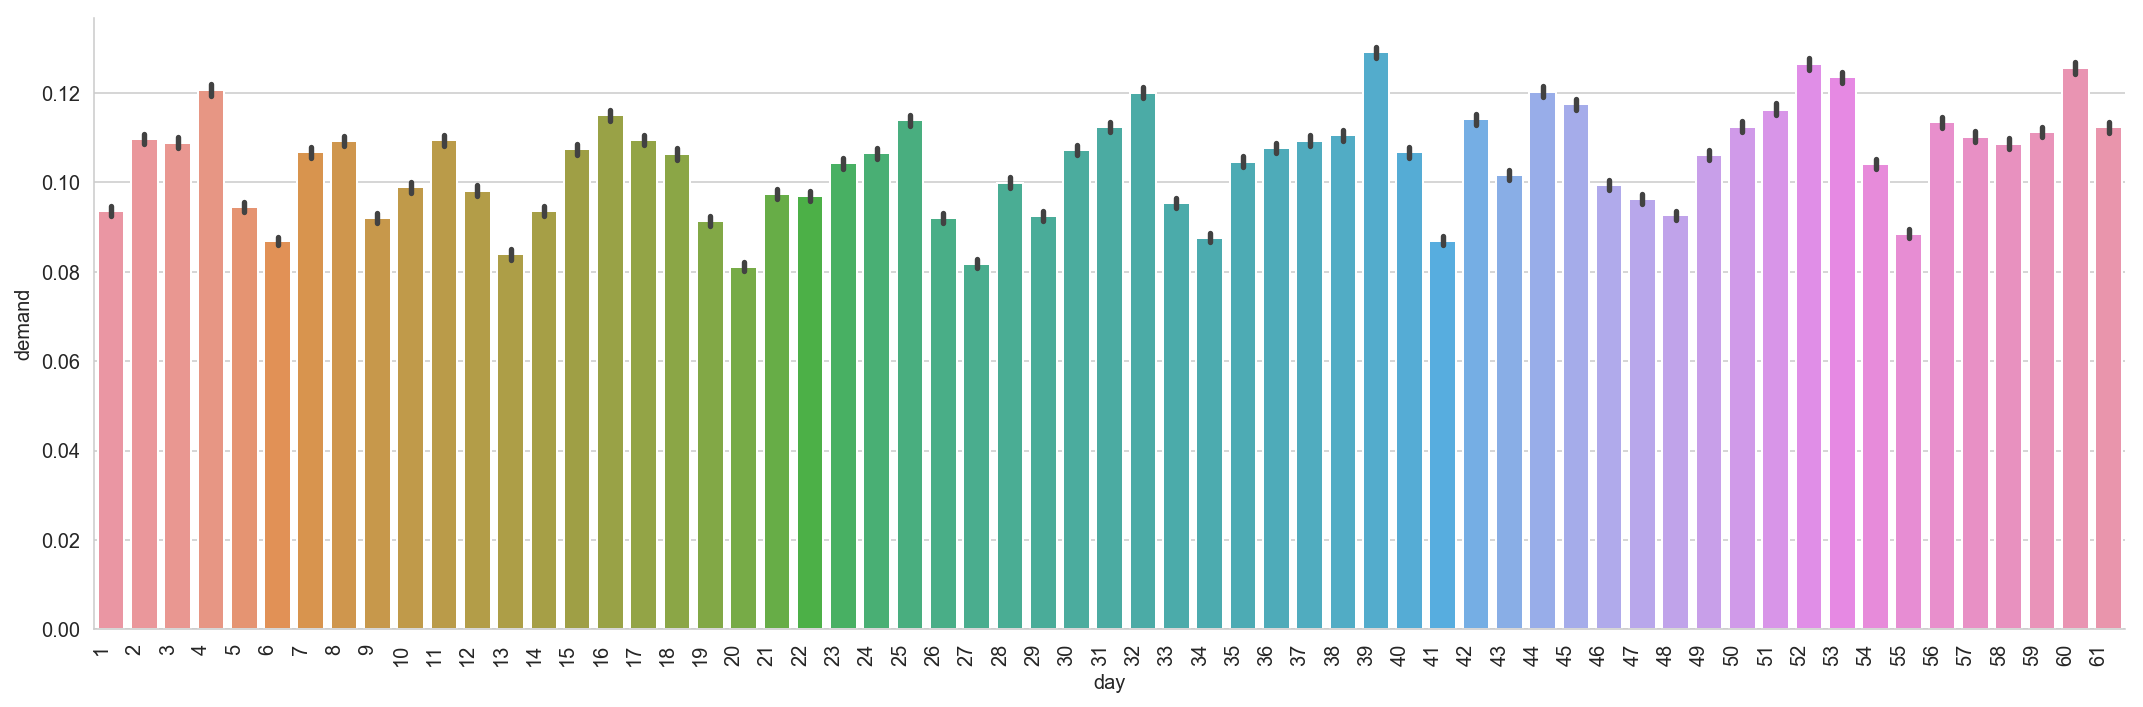

In [80]:
sns.catplot(x='day', y='demand', 
               data=grab_time_sort, kind='bar', aspect=3).set_xticklabels(rotation=90, horizontalalignment='right')

#### We can identify a trend here. after every 5 days, there will be 2 days with low demand

#### However, because the dataset did not specify, we have to make assumptions.
##### - As people tend to take more grab rides during friday and saturday (people tend to go out after work and the 1st day of weekend, i assume that people tend to stay at home on sunday), i will be making the assumption that the highest demand day will be saturday, followed by friday. As such, by working backwards in our dataset, our day 1 is a wednesday.

In [111]:
grab_time_sort.timestamp.value_counts()

9.00     57281
9.15     56983
4.30     56672
5.00     56571
4.45     56493
4.15     56313
8.45     56210
4.00     56158
5.15     56088
6.00     56023
5.45     55999
9.30     55911
5.30     55881
9.45     55867
10.00    55811
6.15     55718
3.45     55689
6.30     55676
8.30     55555
3.30     55425
7.00     55385
8.00     55303
6.45     55296
10.15    55265
7.15     55042
8.15     54981
7.30     54963
7.45     54894
3.15     54889
10.30    54813
         ...  
15.30    37948
22.45    36998
15.45    36179
16.00    34214
22.30    34000
16.15    32296
22.15    31183
16.30    30267
22.00    28765
16.45    28366
17.00    27064
21.45    25910
17.15    25564
21.30    24625
17.30    23962
21.15    23157
17.45    22589
21.00    21865
18.00    21851
18.15    20839
20.45    20086
18.30    19751
20.30    19334
20.15    18823
19.00    18768
18.45    18720
20.00    18611
19.15    18144
19.30    17974
19.45    17720
Name: timestamp, Length: 96, dtype: int64

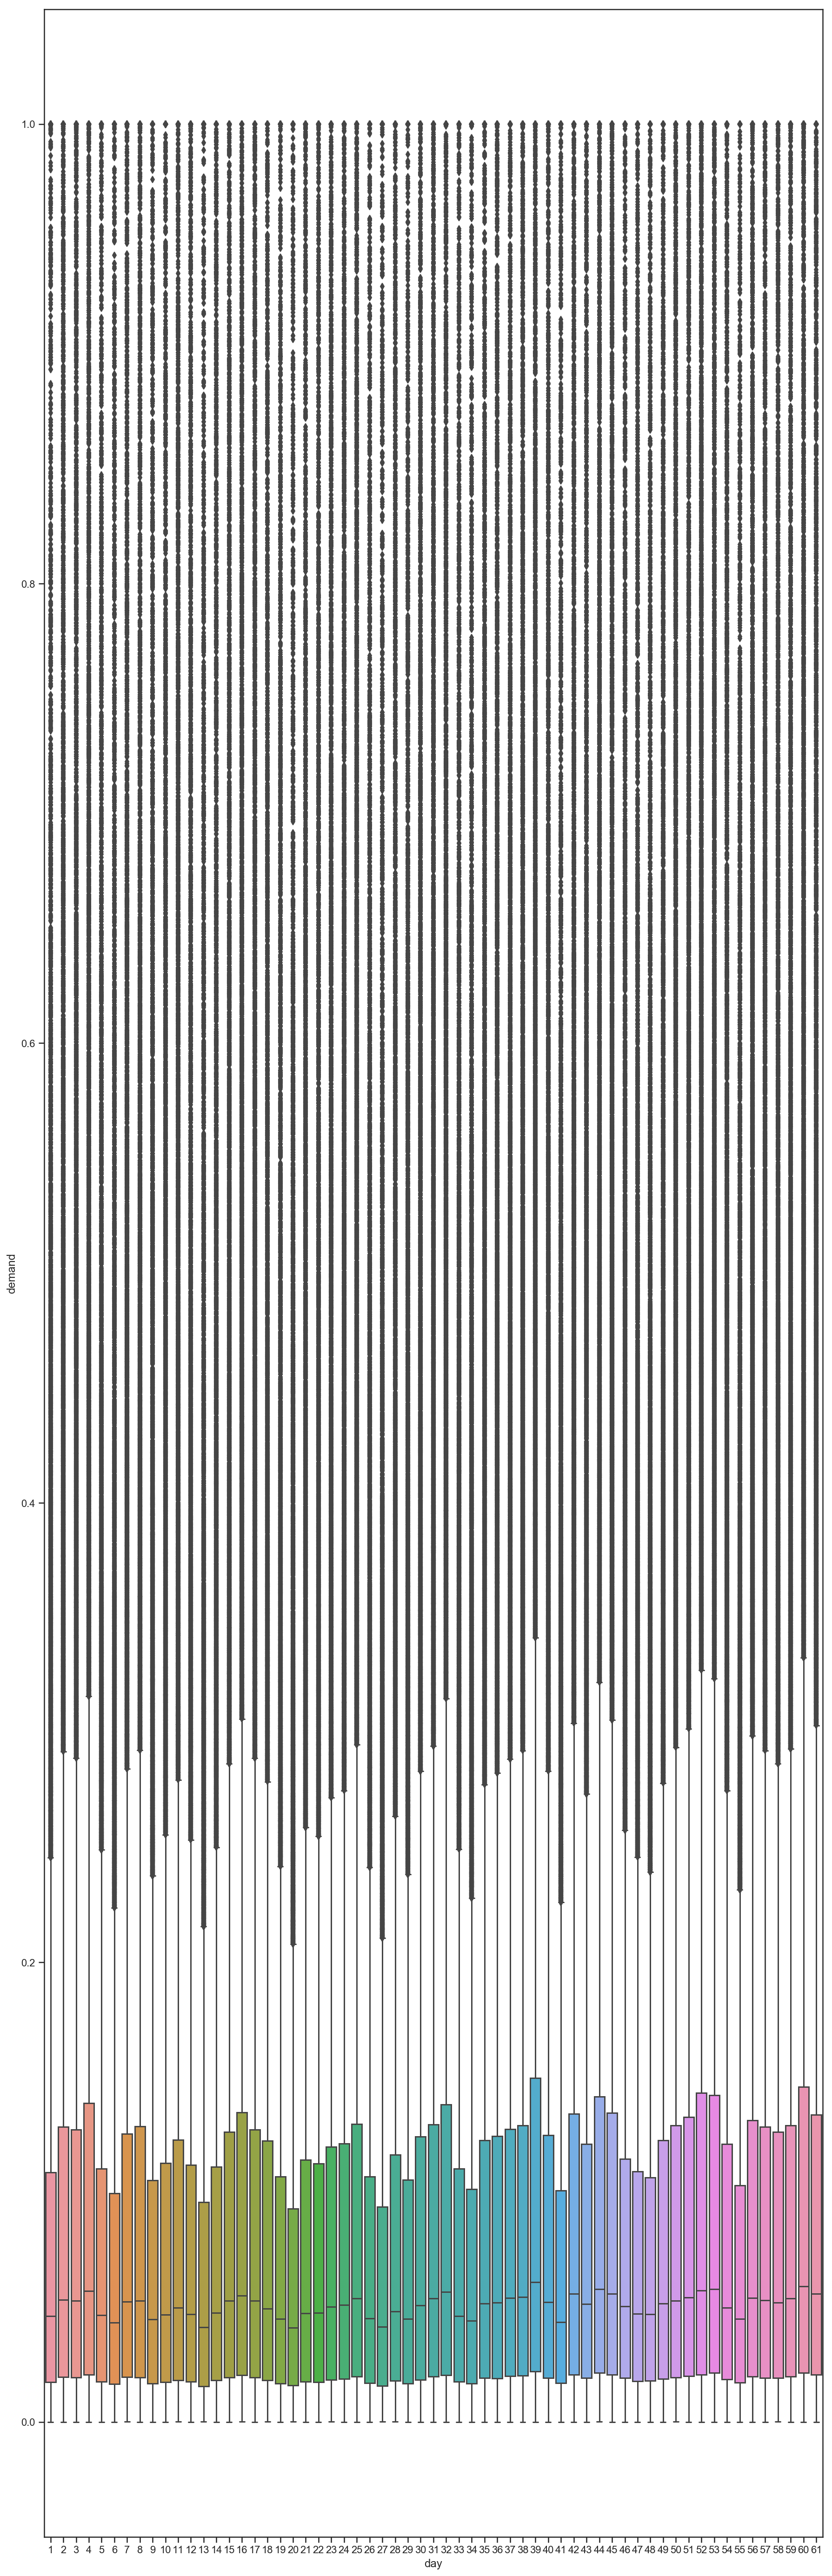

In [23]:
plt.figure(figsize=(15,50))
sns.boxplot(x='day', y='demand', 
               data=grab_train)

In [95]:
grab_train.latitude.nunique()

46

In [96]:
grab_train.longitude.nunique()

36

Text(0.5, 1.0, 'Demand from South -> North ')

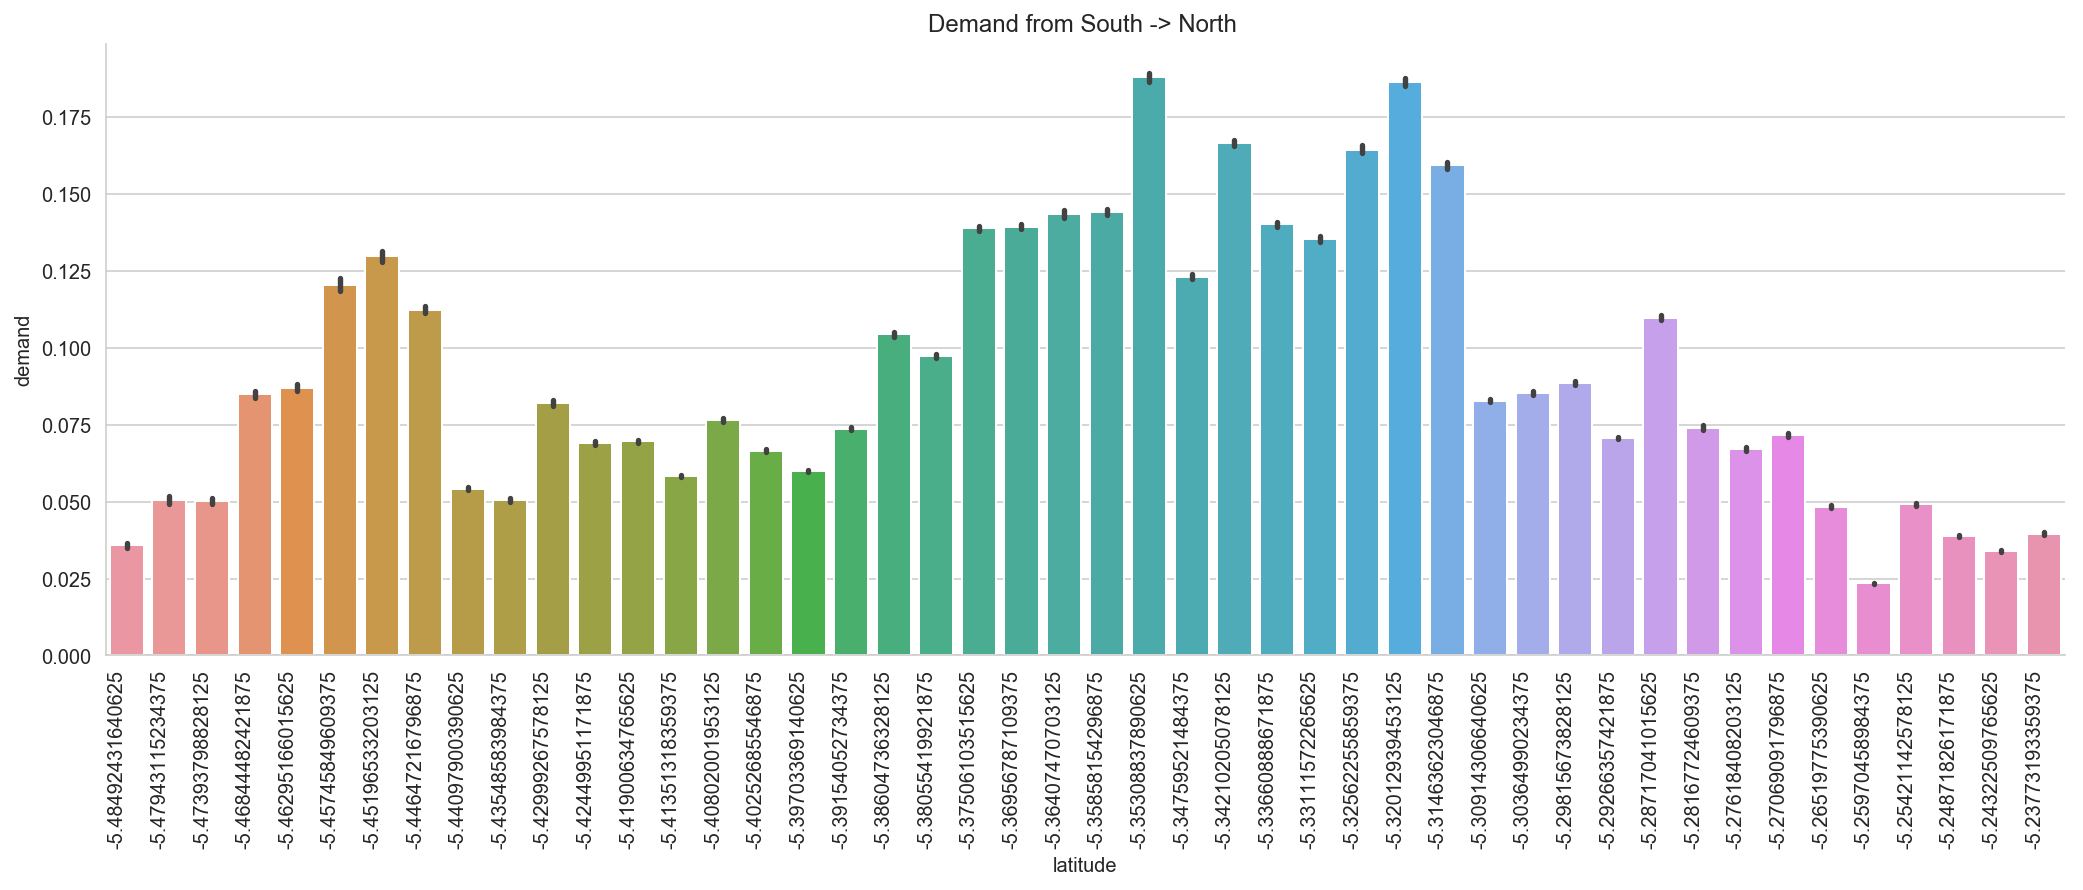

In [156]:
sns.catplot(x='latitude', y='demand', 
               data=grab_time_sort, kind='bar', aspect=3).set_xticklabels(rotation=90, horizontalalignment='right')
plt.title('Demand from South -> North ')

### In general, we can see that central has high demand from latitude plot

Text(0.5, 1.0, 'Demand from West -> East ')

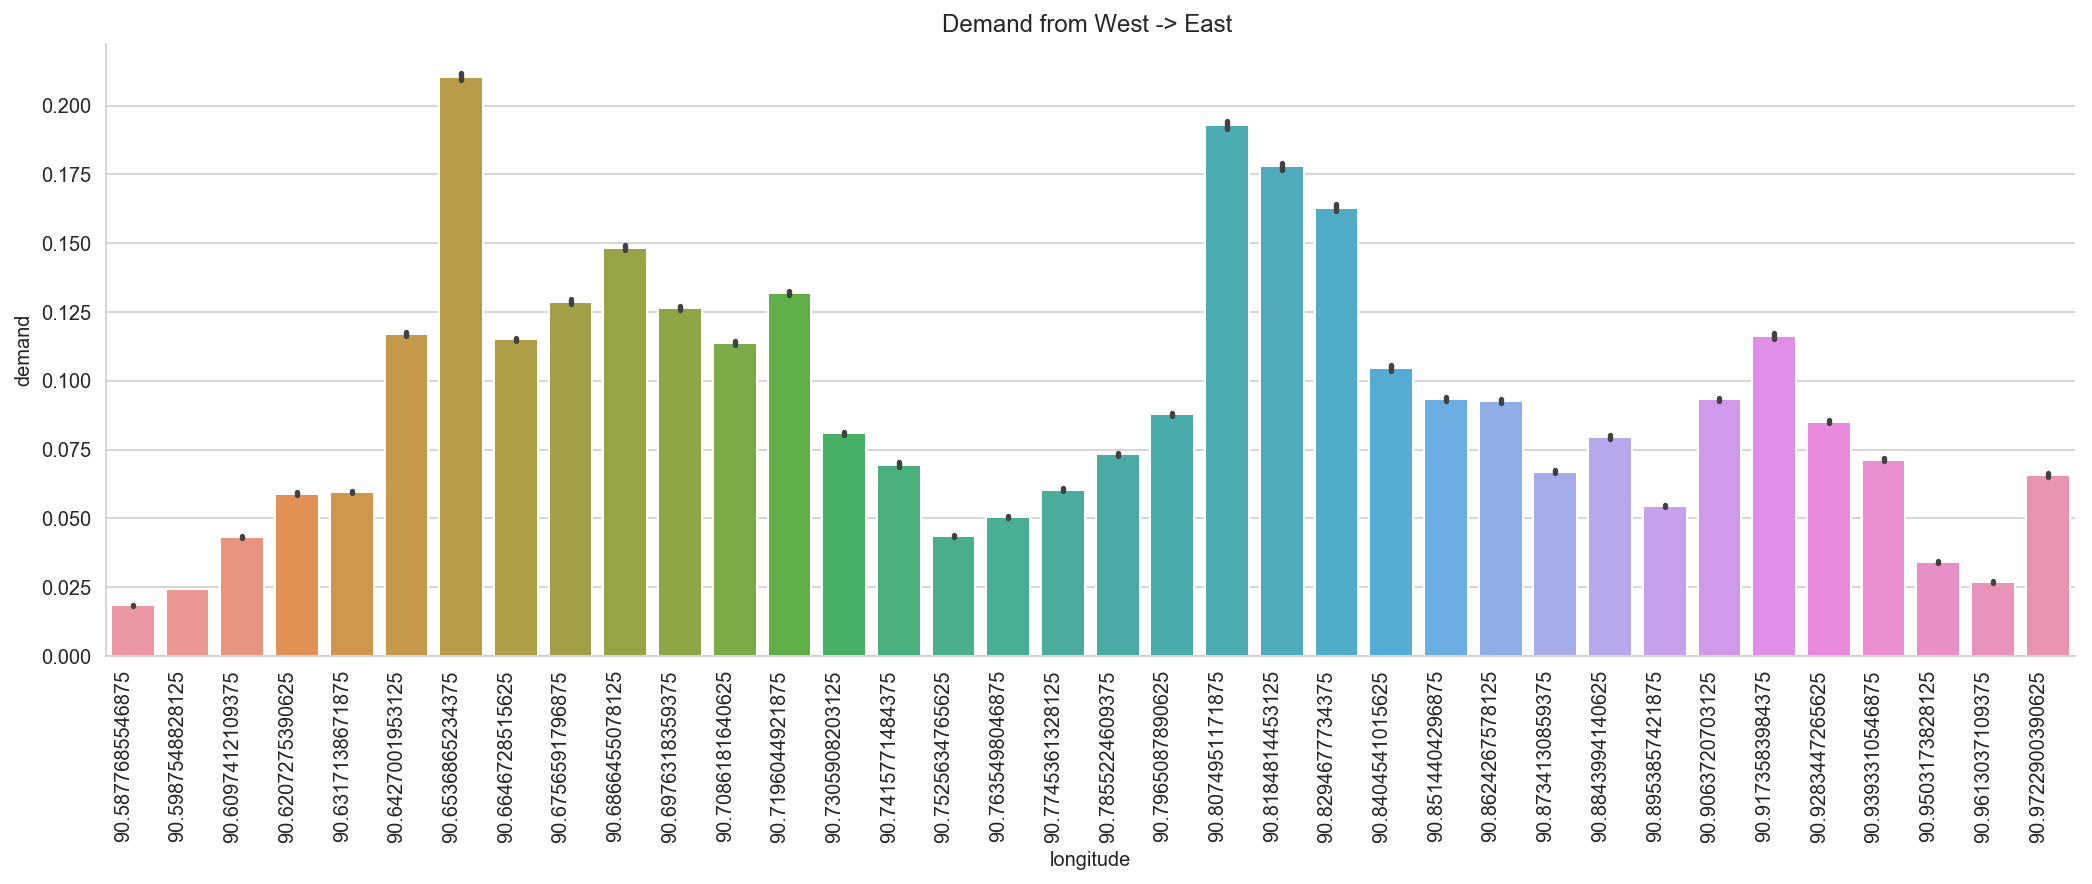

In [155]:
sns.catplot(x='longitude', y='demand', 
               data=grab_time_sort, kind='bar', aspect=3).set_xticklabels(rotation=90, horizontalalignment='right')
plt.title('Demand from West -> East ')

### In general, we can see that Southern, and Central has high demand for longitude plot

In [88]:
grab_train.geohash6.nunique()

1329

In [144]:
grab_train.day.value_counts

<bound method IndexOpsMixin.value_counts of 3504950    27
1258246    16
2010598    48
1258276    46
4072633    39
1258317    18
1258373    19
3283306    57
2436943    44
3283353    27
2010429    51
291155     51
2436979     4
1258605    40
1258622    29
1258637    55
1258723    11
1258767    12
4072593    61
3628444    22
2010199    61
542170     38
4072579    57
2010193    14
1258948     6
148857      7
1258971    30
2010135    34
3957623    50
1259052    32
           ..
1827258     4
2239400    58
3047152    27
1278286    26
2524468     1
1278247    19
3619512    22
3367885    59
1278170     8
3619540     8
2524535    19
3619555     5
2524546    40
3619570    30
1278040    42
3047099     2
3047095    37
2524564     4
1278090    10
1278064    23
2524635    54
413155     45
4081343    24
3047046    36
3178207     7
3367873    39
3047028     5
3047019    30
1278095    36
2096778    15
Name: day, Length: 4206321, dtype: int64>

In [34]:
grab_train.timestamp.value_counts()

9:0      57281
9:15     56983
4:30     56672
5:0      56571
4:45     56493
4:15     56313
8:45     56210
4:0      56158
5:15     56088
6:0      56023
5:45     55999
9:30     55911
5:30     55881
9:45     55867
10:0     55811
6:15     55718
3:45     55689
6:30     55676
8:30     55555
3:30     55425
7:0      55385
8:0      55303
6:45     55296
10:15    55265
7:15     55042
8:15     54981
7:30     54963
7:45     54894
3:15     54889
10:30    54813
         ...  
15:30    37948
22:45    36998
15:45    36179
16:0     34214
22:30    34000
16:15    32296
22:15    31183
16:30    30267
22:0     28765
16:45    28366
17:0     27064
21:45    25910
17:15    25564
21:30    24625
17:30    23962
21:15    23157
17:45    22589
21:0     21865
18:0     21851
18:15    20839
20:45    20086
18:30    19751
20:30    19334
20:15    18823
19:0     18768
18:45    18720
20:0     18611
19:15    18144
19:30    17974
19:45    17720
Name: timestamp, Length: 96, dtype: int64

# Feature Engineering

### First, we need to assign day of the week to days, even though we do not know day 1 is which day of the week, but we can make assumptions as mentioned earlier. Day 1 to start with wednesday.

### Second, we can consider creating different tiers for peak/non-peak hours.

### Third, we create dummy columns for time

### Fourth, we need to identify the districts. Which is neighbourhood, which is CBD, which is clarkquay(night spots), which is sentosa, which is airport etc. This is because the demand for ALL areas differ. So we need to categorize them accordingly to make our model more accurate.

In [178]:
grab_train.head()

geohash6  day timestamp    demand  latitude  longitude
2021861   qp02yc    1     11:15  0.013487 -5.484924  90.653687
1403484   qp02yc    1      12:0  0.003709 -5.484924  90.653687
2873712   qp02yc    1      2:45  0.020592 -5.484924  90.653687
2643238   qp02yc    1       3:0  0.010292 -5.484924  90.653687
1791986   qp02yc    1       4:0  0.006676 -5.484924  90.653687

## 1. Weekdays

In [37]:
grab_train['day_week'] = grab_train['day']

In [38]:
grab_train.head()

geohash6  day timestamp    demand  latitude  longitude  day_week
3849049   qp093q   56       0:0  0.020689 -5.369568  90.763550        56
902676    qp09fw   40       0:0  0.008320 -5.281677  90.818481        40
1047754   qp092j   29       0:0  0.229908 -5.375061  90.708618        29
4107759   qp02zy   31       0:0  0.088888 -5.457458  90.697632        31
95122     qp09un   43       0:0  0.054890 -5.281677  90.884399        43

In [39]:
weekdays = []
for weekday in grab_train.day_week.tolist():
    if weekday == 1 or weekday == 1+7 or weekday == 1+14 or weekday == 1+21 or weekday == 1+28 or weekday == 1+35 or weekday == 1+42 or weekday == 1+49 or weekday == 1+56:
        weekdays.append("Tuesday")
    if weekday == 2 or weekday == 2+7 or weekday == 2+14 or weekday == 2+21 or weekday == 2+28 or weekday == 2+35 or weekday == 2+42 or weekday == 2+49 or weekday == 2+56:
        weekdays.append("Wednesday")
    if weekday == 3 or weekday == 3+7 or weekday == 3+14 or weekday == 3+21 or weekday == 3+28 or weekday == 3+35 or weekday == 3+42 or weekday == 3+49 or weekday == 3+56:
        weekdays.append("Thursday")
    if weekday == 4 or weekday == 4+7 or weekday == 4+14 or weekday == 4+21 or weekday == 4+28 or weekday == 4+35 or weekday == 4+42 or weekday == 4+49 or weekday == 4+56:
        weekdays.append("Friday")
    if weekday == 5 or weekday == 5+7 or weekday == 5+14 or weekday == 5+21 or weekday == 5+28 or weekday == 5+35 or weekday == 5+42 or weekday == 5+49 or weekday == 5+56:
        weekdays.append("Saturday")
    if weekday == 6 or weekday == 6+7 or weekday == 6+14 or weekday == 6+21 or weekday == 6+28 or weekday == 6+35 or weekday == 6+42 or weekday == 6+49:        
        weekdays.append("Sunday")
    if weekday == 7 or weekday == 7+7 or weekday == 7+14 or weekday == 7+21 or weekday == 7+28 or weekday == 7+35 or weekday == 7+42 or weekday == 7+49:      
        weekdays.append("Monday")

In [40]:
grab_train['day_week'] = weekdays

In [41]:
grab_train.head(10)

geohash6  day timestamp    demand  latitude  longitude  day_week
3849049   qp093q   56       0:0  0.020689 -5.369568  90.763550    Monday
902676    qp09fw   40       0:0  0.008320 -5.281677  90.818481  Saturday
1047754   qp092j   29       0:0  0.229908 -5.375061  90.708618   Tuesday
4107759   qp02zy   31       0:0  0.088888 -5.457458  90.697632  Thursday
95122     qp09un   43       0:0  0.054890 -5.281677  90.884399   Tuesday
169842    qp09b3   60       0:0  0.095473 -5.309143  90.719604    Friday
3076413   qp03pr    6       0:0  0.061302 -5.408020  90.675659    Sunday
588000    qp03rp   54       0:0  0.029261 -5.364075  90.664673  Saturday
2386613   qp09s6   57       0:0  0.075980 -5.347595  90.895386   Tuesday
2955498   qp098m   17       0:0  0.115816 -5.331116  90.719604  Thursday

In [117]:
len(grab_train.day_week)

4206321

In [42]:
weekday_weekend = []
for weekday in grab_train.day_week.tolist():
    if weekday == 'Monday' or weekday =='Tuesday' or weekday=='Wednesday' or weekday=='Thursday' or weekday =='Friday':
        weekday_weekend.append(1)
    else:
        weekday_weekend.append(0)
        
len(weekday_weekend)

4206321

In [43]:
grab_train['weekday']=weekday_weekend

In [44]:
grab_train.head(5)

geohash6  day timestamp    demand  latitude  longitude  day_week  \
3849049   qp093q   56       0:0  0.020689 -5.369568  90.763550    Monday   
902676    qp09fw   40       0:0  0.008320 -5.281677  90.818481  Saturday   
1047754   qp092j   29       0:0  0.229908 -5.375061  90.708618   Tuesday   
4107759   qp02zy   31       0:0  0.088888 -5.457458  90.697632  Thursday   
95122     qp09un   43       0:0  0.054890 -5.281677  90.884399   Tuesday   

         weekday  
3849049        1  
902676         0  
1047754        1  
4107759        1  
95122          1

## 2. We need to set the respective peak hours.
#### - weekday morning peak would affect neighbourhood demand
#### - weekday evening peak would affect CBD demand
#### - weekday after evening peak would affect town demand
#### - weekend would affect islandwide demand

#### eg. daily Midnight 1am to 6am (no public transport)
#### eg. weekday Morning Peak1 6am to 7am
#### eg. weekday Morning Peak2 7am to 8am
#### eg. weekday Morning Peak3 8am to 9am
#### eg. weekday After MorningPeak4 9am to 10am
#### eg. Others 10am to 5pm
#### eg. weekday Before Evening Peak5 5pm to 6pm
#### eg. weekday Evening Peak6 6pm to 7pm
#### eg. weekday Evening Peak7 7pm to 8pm
#### eg. weekday After Evening Peak8 8pm to 10pm
#### eg. weekday Late night peak (office transport claims & people rushing home) 10pm to 1am


In [45]:
grab_time_sort = grab_train.copy()
grab_time_sort.head()

geohash6  day timestamp    demand  latitude  longitude  day_week  \
3849049   qp093q   56       0:0  0.020689 -5.369568  90.763550    Monday   
902676    qp09fw   40       0:0  0.008320 -5.281677  90.818481  Saturday   
1047754   qp092j   29       0:0  0.229908 -5.375061  90.708618   Tuesday   
4107759   qp02zy   31       0:0  0.088888 -5.457458  90.697632  Thursday   
95122     qp09un   43       0:0  0.054890 -5.281677  90.884399   Tuesday   

         weekday  
3849049        1  
902676         0  
1047754        1  
4107759        1  
95122          1

In [46]:
midnight = []
grab_time_sort['timestamp'] = grab_time_sort['timestamp'].apply(lambda x: float(x.replace(':','.')))

for time in grab_time_sort.timestamp.tolist():
    if time>1 and time <6:
        midnight.append(1)
    else:
        midnight.append(0)
        
grab_train['midnight_1am-6am']=midnight

In [47]:
peak1 = []
peak2 = []
peak3 = []
peak4 = []

for time in grab_time_sort.timestamp.tolist():
    if time>=6 and time <7:
        peak1.append(1)
    else:
        peak1.append(0)
        
grab_train['peak1_6am-7am']=peak1


for time in grab_time_sort.timestamp.tolist():
    if time>=7 and time <8:
        peak2.append(1)
    else:
        peak2.append(0)
        
grab_train['peak2_7am-8am']=peak2

for time in grab_time_sort.timestamp.tolist():
    if time>=8 and time <9:
        peak3.append(1)
    else:
        peak3.append(0)
        
grab_train['peak3_8am-9am']=peak3

for time in grab_time_sort.timestamp.tolist():
    if time>=9 and time <10:
        peak4.append(1)
    else:
        peak4.append(0)
        
grab_train['peak4_9am-10am']=peak4

In [48]:
others = []

for time in grab_time_sort.timestamp.tolist():
    if time>=10 and time <17:
        others.append(1)
    else:
        others.append(0)
        
grab_train['non_peak_10am-5pm']=others

In [49]:
peak5 = []
peak6 = []
peak7 = []
peak8 = []

for time in grab_time_sort.timestamp.tolist():
    if time>=17 and time <18:
        peak5.append(1)
    else:
        peak5.append(0)
        
grab_train['peak5_5pm-6pm']=peak5


for time in grab_time_sort.timestamp.tolist():
    if time>=18 and time <19:
        peak6.append(1)
    else:
        peak6.append(0)
        
grab_train['peak6_6pm-7pm']=peak6

for time in grab_time_sort.timestamp.tolist():
    if time>=19 and time <20:
        peak7.append(1)
    else:
        peak7.append(0)
        
grab_train['peak7_7pm-8pm']=peak7

for time in grab_time_sort.timestamp.tolist():
    if time>=20 and time <22:
        peak8.append(1)
    else:
        peak8.append(0)
        
grab_train['peak8_8pm-10pm']=peak8

In [50]:
late_night = []

for time in grab_time_sort.timestamp.tolist():
    if time>=22 and time <24 or time>=0 and time <1:
        late_night.append(1)
    else:
        late_night.append(0)
        
grab_train['night_10pm-1am']=late_night

In [51]:
grab_train.head()

geohash6  day timestamp    demand  latitude  longitude  day_week  \
3849049   qp093q   56       0:0  0.020689 -5.369568  90.763550    Monday   
902676    qp09fw   40       0:0  0.008320 -5.281677  90.818481  Saturday   
1047754   qp092j   29       0:0  0.229908 -5.375061  90.708618   Tuesday   
4107759   qp02zy   31       0:0  0.088888 -5.457458  90.697632  Thursday   
95122     qp09un   43       0:0  0.054890 -5.281677  90.884399   Tuesday   

         weekday  midnight_1am-6am  peak1_6am-7am  peak2_7am-8am  \
3849049        1                 0              0              0   
902676         0                 0              0              0   
1047754        1                 0              0              0   
4107759        1                 0              0              0   
95122          1                 0              0              0   

         peak3_8am-9am  peak4_9am-10am  non_peak_10am-5pm  peak5_5pm-6pm  \
3849049              0               0                  0              0   
902676               0               0                  0              0   
1047754              0               0                  0              0   
4107759              0               0                  0              0   
95122                0               0                  0              0   

         peak6_6pm-7pm  peak7_7pm-8pm  peak8_8pm-10pm  night_10pm-1am  
3849049              0              0               0               1  
902676               0              0               0               1  
1047754              0              0               0               1  
4107759              0              0               0               1  
95122                0              0               0               1

## 3. Dummify Timestamps and day of the week

In [52]:
grab_train.dtypes

geohash6              object
day                    int64
timestamp             object
demand               float64
latitude             float64
longitude            float64
day_week              object
weekday                int64
midnight_1am-6am       int64
peak1_6am-7am          int64
peak2_7am-8am          int64
peak3_8am-9am          int64
peak4_9am-10am         int64
non_peak_10am-5pm      int64
peak5_5pm-6pm          int64
peak6_6pm-7pm          int64
peak7_7pm-8pm          int64
peak8_8pm-10pm         int64
night_10pm-1am         int64
dtype: object

In [53]:
grab_train.columns.tolist()

['geohash6',
 'day',
 'timestamp',
 'demand',
 'latitude',
 'longitude',
 'day_week',
 'weekday',
 'midnight_1am-6am',
 'peak1_6am-7am',
 'peak2_7am-8am',
 'peak3_8am-9am',
 'peak4_9am-10am',
 'non_peak_10am-5pm',
 'peak5_5pm-6pm',
 'peak6_6pm-7pm',
 'peak7_7pm-8pm',
 'peak8_8pm-10pm',
 'night_10pm-1am']

In [54]:
geo_has = grab_train['geohash6']

In [55]:
grab_train.drop('geohash6', axis=1, inplace=True)

In [56]:
grab_train.columns.tolist()

['day',
 'timestamp',
 'demand',
 'latitude',
 'longitude',
 'day_week',
 'weekday',
 'midnight_1am-6am',
 'peak1_6am-7am',
 'peak2_7am-8am',
 'peak3_8am-9am',
 'peak4_9am-10am',
 'non_peak_10am-5pm',
 'peak5_5pm-6pm',
 'peak6_6pm-7pm',
 'peak7_7pm-8pm',
 'peak8_8pm-10pm',
 'night_10pm-1am']

In [57]:
grab_dummified = pd.get_dummies(grab_train)

In [58]:
grab_dummified.columns.tolist()

['day',
 'demand',
 'latitude',
 'longitude',
 'weekday',
 'midnight_1am-6am',
 'peak1_6am-7am',
 'peak2_7am-8am',
 'peak3_8am-9am',
 'peak4_9am-10am',
 'non_peak_10am-5pm',
 'peak5_5pm-6pm',
 'peak6_6pm-7pm',
 'peak7_7pm-8pm',
 'peak8_8pm-10pm',
 'night_10pm-1am',
 'timestamp_0:0',
 'timestamp_0:15',
 'timestamp_0:30',
 'timestamp_0:45',
 'timestamp_10:0',
 'timestamp_10:15',
 'timestamp_10:30',
 'timestamp_10:45',
 'timestamp_11:0',
 'timestamp_11:15',
 'timestamp_11:30',
 'timestamp_11:45',
 'timestamp_12:0',
 'timestamp_12:15',
 'timestamp_12:30',
 'timestamp_12:45',
 'timestamp_13:0',
 'timestamp_13:15',
 'timestamp_13:30',
 'timestamp_13:45',
 'timestamp_14:0',
 'timestamp_14:15',
 'timestamp_14:30',
 'timestamp_14:45',
 'timestamp_15:0',
 'timestamp_15:15',
 'timestamp_15:30',
 'timestamp_15:45',
 'timestamp_16:0',
 'timestamp_16:15',
 'timestamp_16:30',
 'timestamp_16:45',
 'timestamp_17:0',
 'timestamp_17:15',
 'timestamp_17:30',
 'timestamp_17:45',
 'timestamp_18:0',
 'timest

## 4. Play with lat and lon, we need to identify the districts. Which is neighbourhood, which is CBD, which is clarkquay(night spots), which is sentosa, which is airport etc. This is because the demand for ALL areas differ at different timing. So we need to categorize them accordingly to make our model more accurate.

### a) Let's look at the daily demand EDA for peak 3 and peak 6 to see if our assumption made for days of the week is on the right track

- 'midnight_1am-6am',
- 'peak1_6am-7am',
- 'peak2_7am-8am',
- **'peak3_8am-9am'**,
- 'peak4_9am-10am',
- 'non_peak_10am-5pm',
- 'peak5_5pm-6pm',
- **'peak6_6pm-7pm'**,
- 'peak7_7pm-8pm',
- 'peak8_8pm-10pm',
- 'night_10pm-1am'

In [59]:
day_week = [
 'day_week_Monday',
 'day_week_Tuesday',
 'day_week_Wednesday',
 'day_week_Thursday',
 'day_week_Friday',
 'day_week_Saturday',
 'day_week_Sunday',]

In [60]:
grab_dummified.head()

day    demand  latitude  longitude  weekday  midnight_1am-6am  \
3849049   56  0.020689 -5.369568  90.763550        1                 0   
902676    40  0.008320 -5.281677  90.818481        0                 0   
1047754   29  0.229908 -5.375061  90.708618        1                 0   
4107759   31  0.088888 -5.457458  90.697632        1                 0   
95122     43  0.054890 -5.281677  90.884399        1                 0   

         peak1_6am-7am  peak2_7am-8am  peak3_8am-9am  peak4_9am-10am  \
3849049              0              0              0               0   
902676               0              0              0               0   
1047754              0              0              0               0   
4107759              0              0              0               0   
95122                0              0              0               0   

                ...          timestamp_9:15  timestamp_9:30  timestamp_9:45  \
3849049         ...                       0               0               0   
902676          ...                       0               0               0   
1047754         ...                       0               0               0   
4107759         ...                       0               0               0   
95122           ...                       0               0               0   

         day_week_Friday  day_week_Monday  day_week_Saturday  day_week_Sunday  \
3849049                0                1                  0                0   
902676                 0                0                  1                0   
1047754                0                0                  0                0   
4107759                0                0                  0                0   
95122                  0                0                  0                0   

         day_week_Thursday  day_week_Tuesday  day_week_Wednesday  
3849049                  0                 0                   0  
902676                   0                 0                   0  
1047754                  0                 1                   0  
4107759                  1                 0                   0  
95122                    0                 1                   0  

[5 rows x 119 columns]

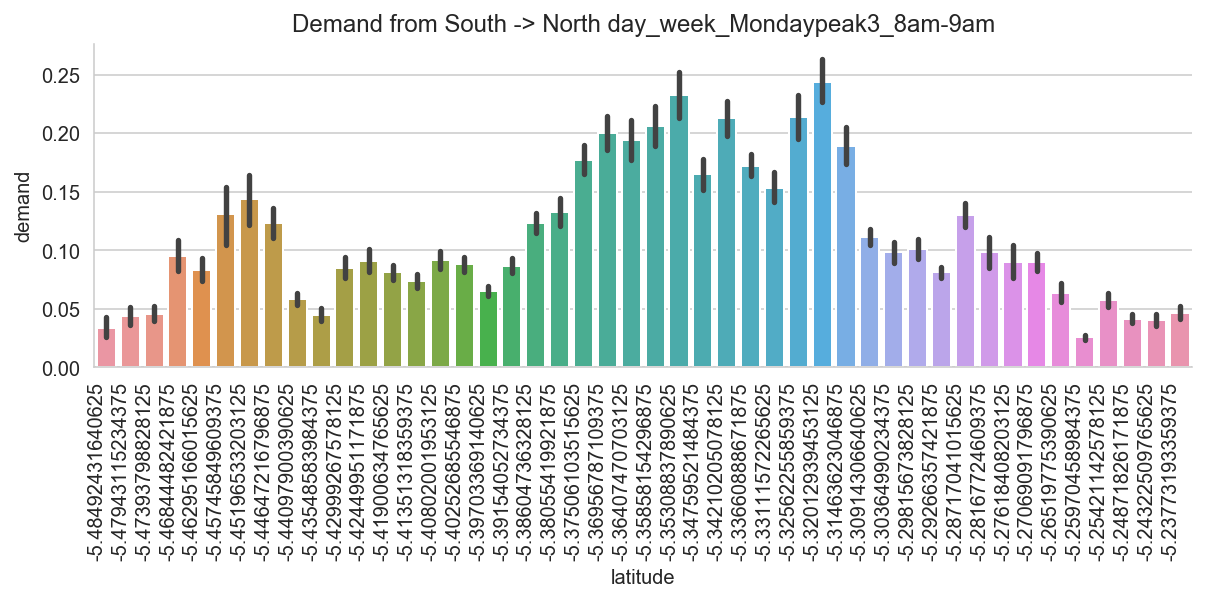

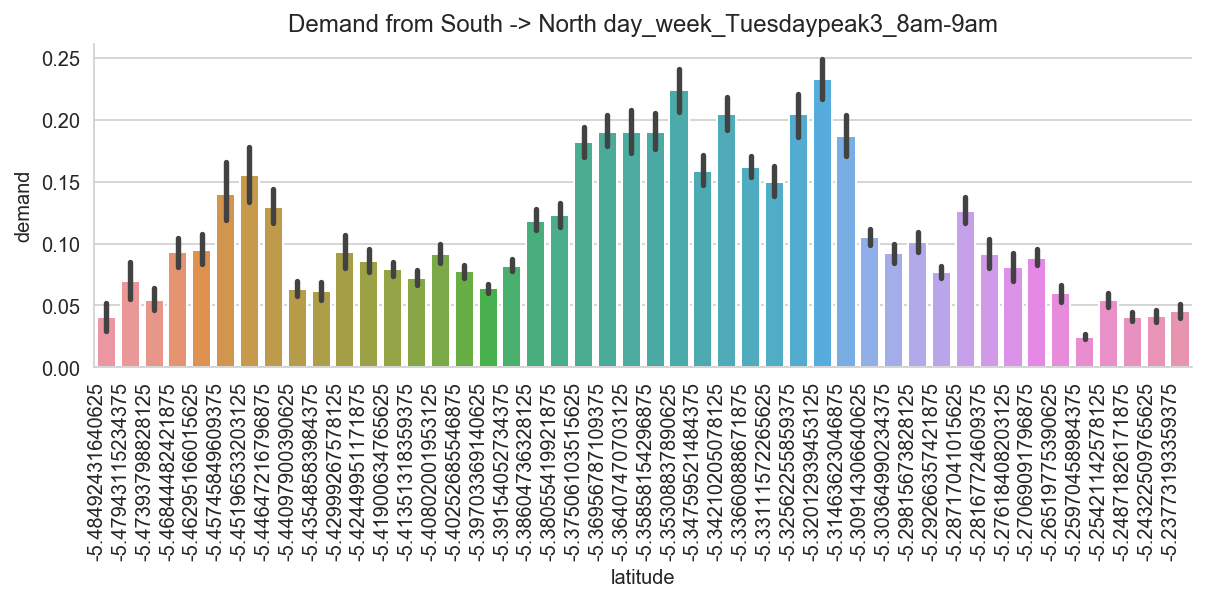

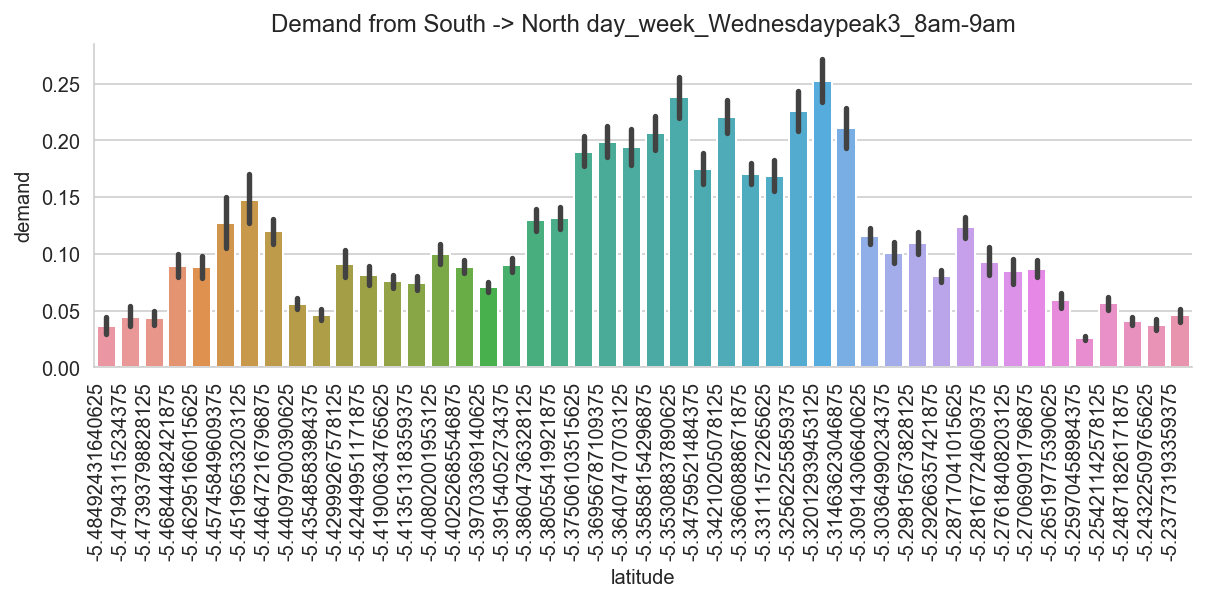

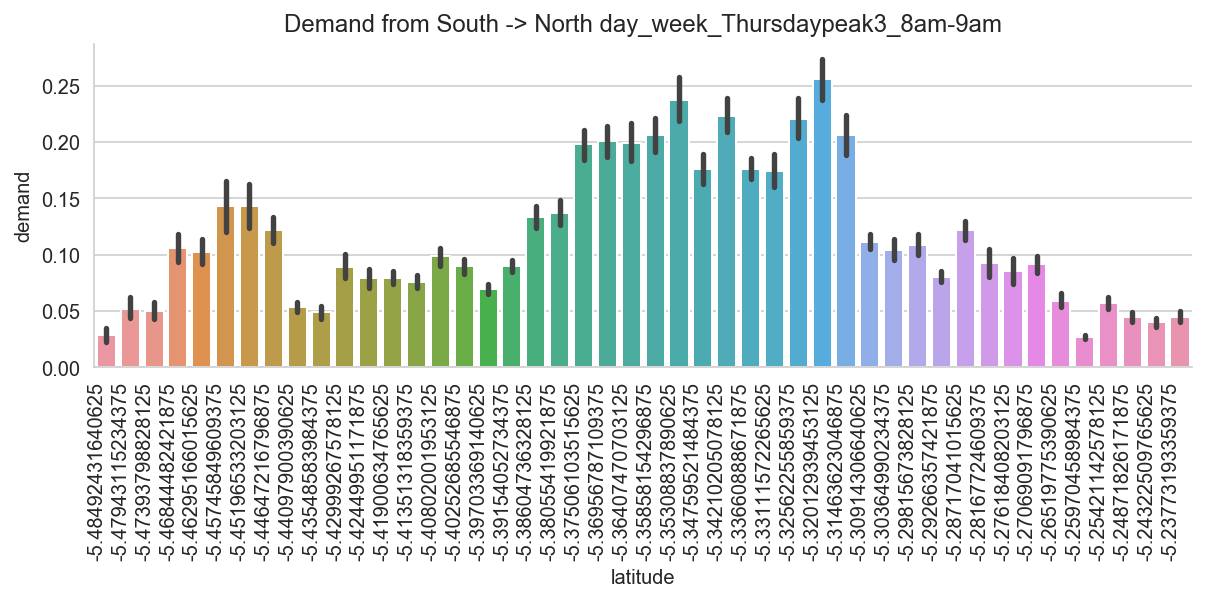

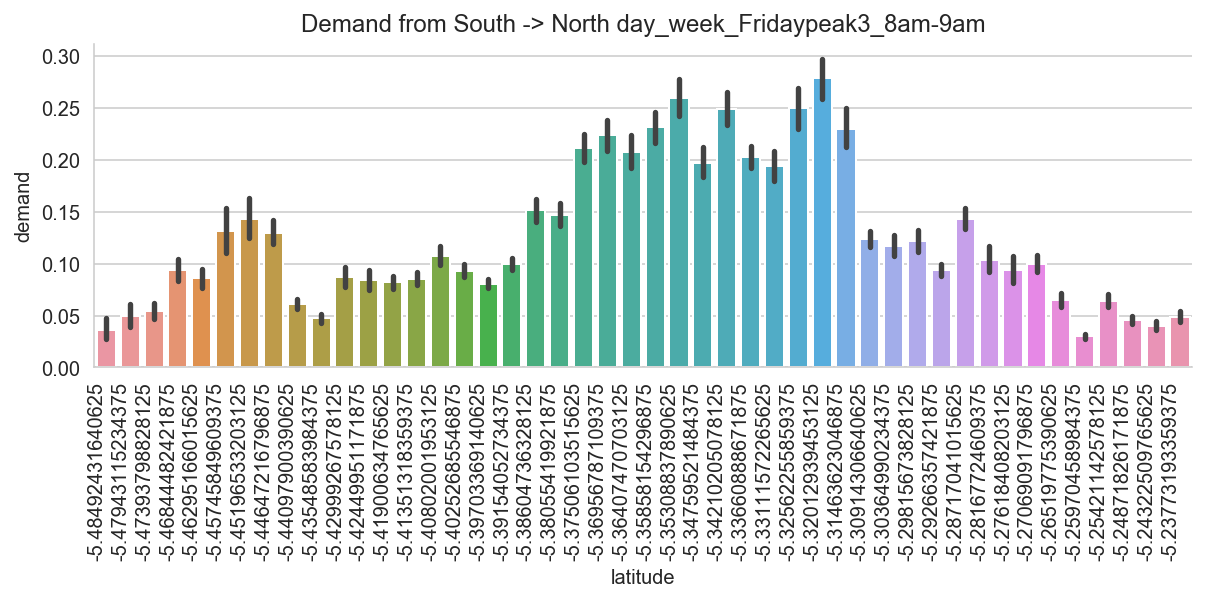

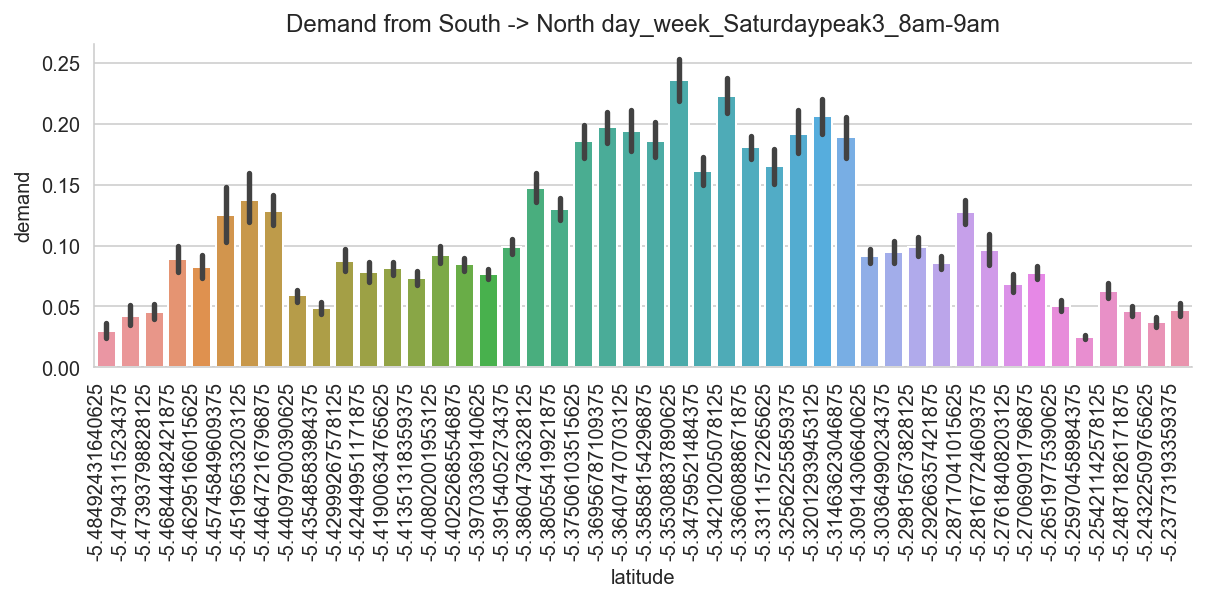

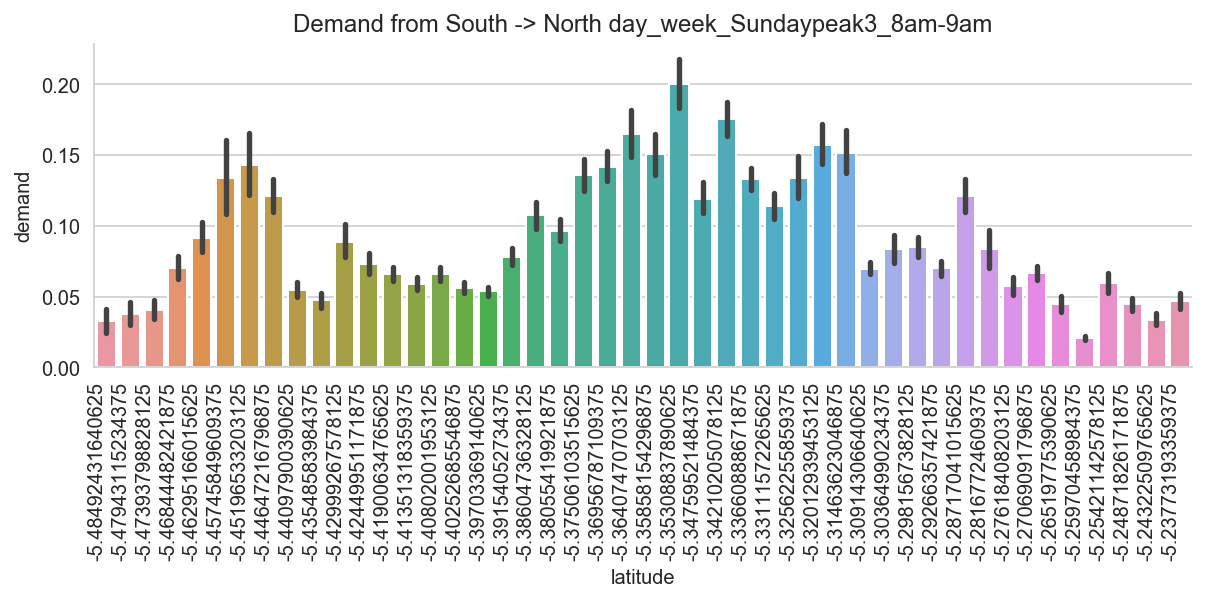

In [238]:
for period in day_week:
    sns.catplot(x='latitude', y='demand', height=3,
                   data=grab_dummified[grab_dummified['peak3_8am-9am']==1][grab_dummified[period]==1], kind='bar', aspect=3).set_xticklabels(rotation=90, horizontalalignment='right')
    plt.title('Demand from South -> North '+ str(period)+ 'peak3_8am-9am')

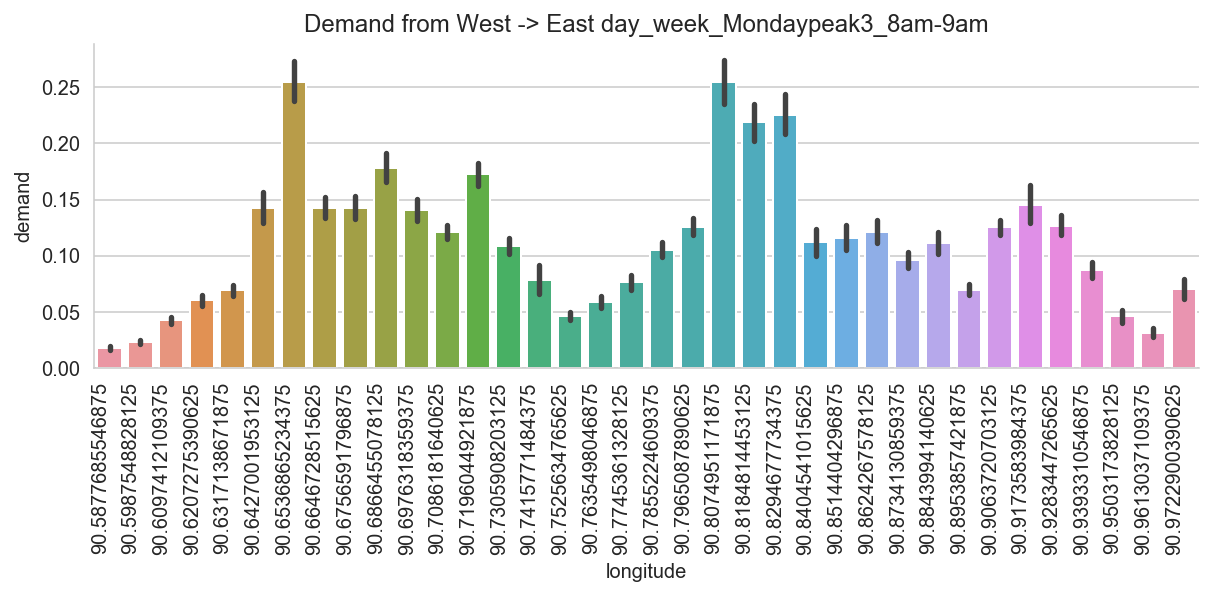

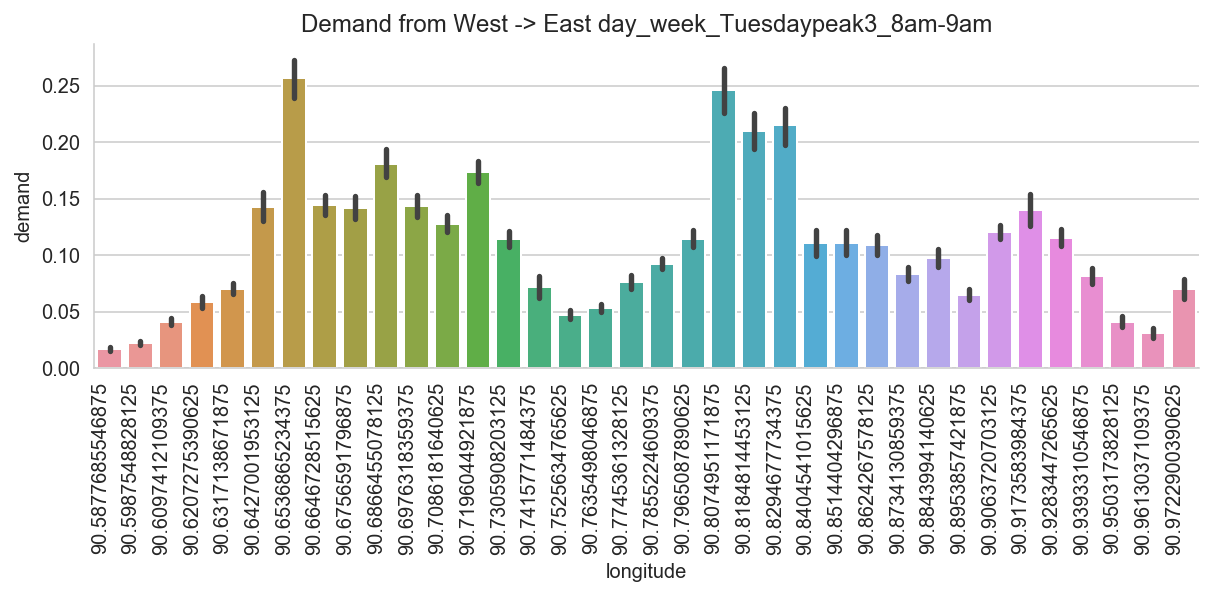

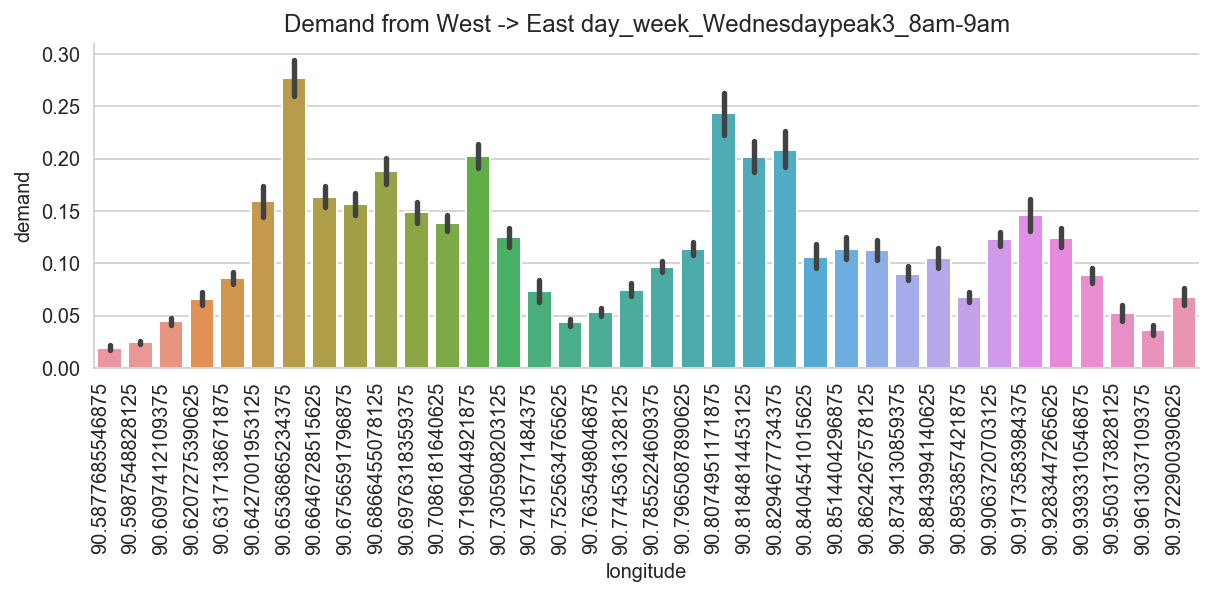

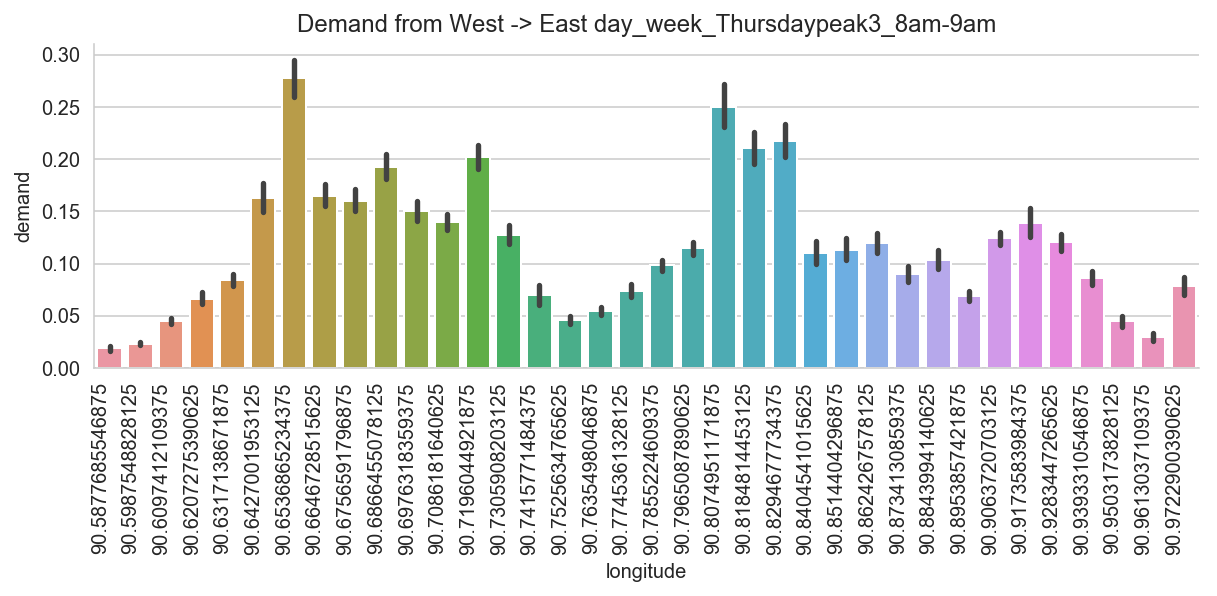

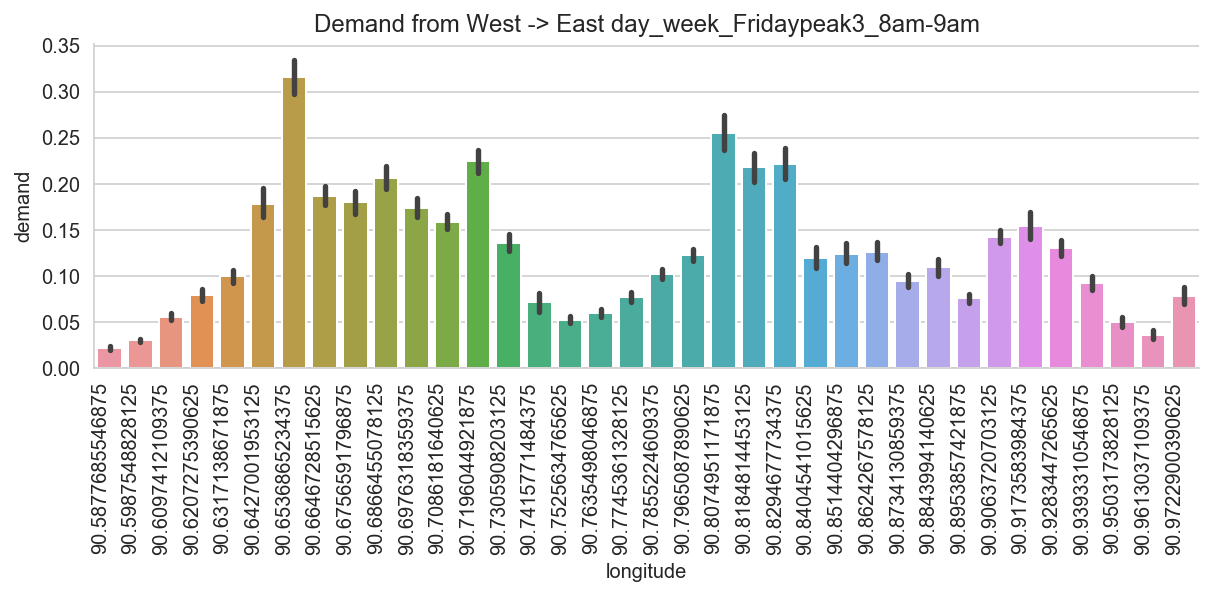

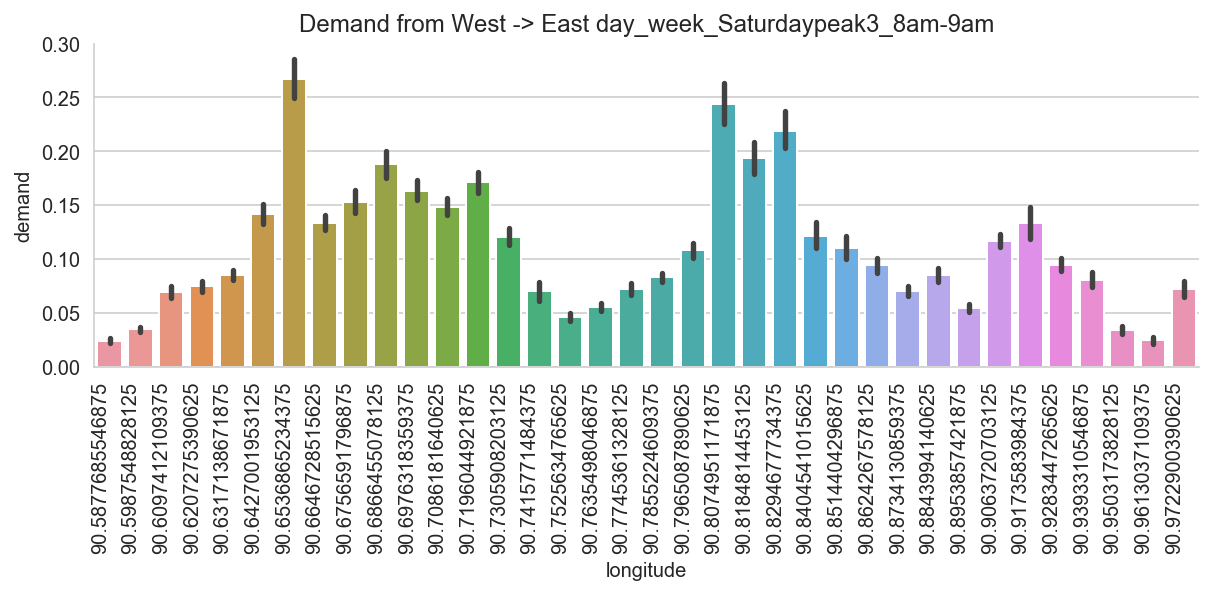

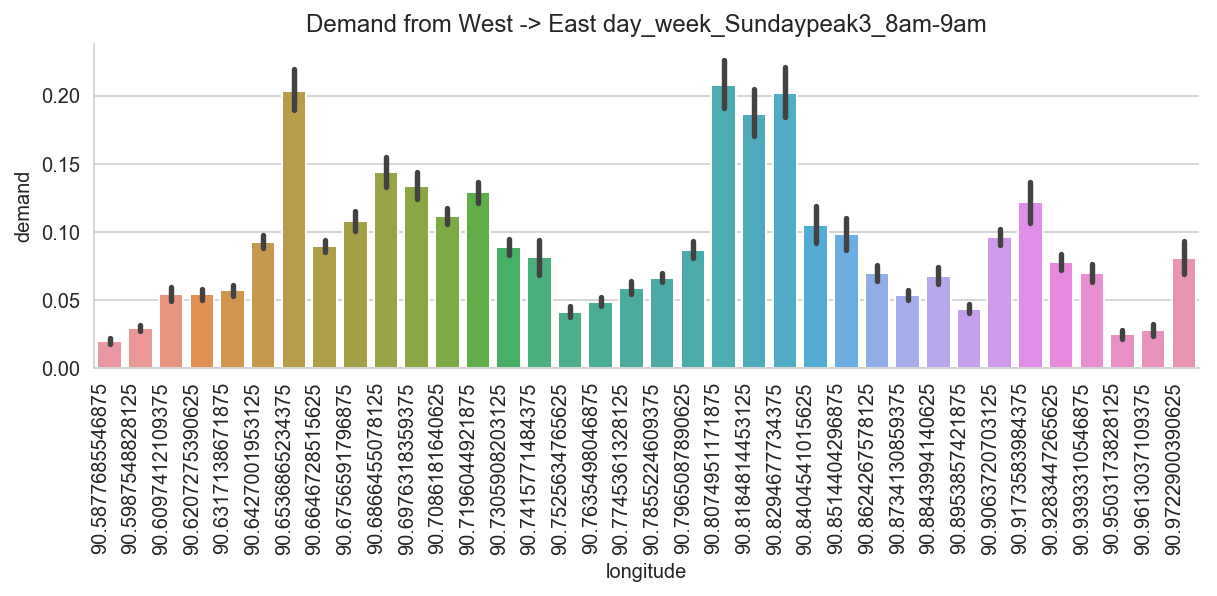

In [154]:
for period in day_week:
    sns.catplot(x='longitude', y='demand', height=3,
                   data=grab_dummified[grab_dummified['peak3_8am-9am']==1][grab_dummified[period]==1], kind='bar', aspect=3).set_xticklabels(rotation=90, horizontalalignment='right')
    plt.title('Demand from West -> East '+ str(period)+ 'peak3_8am-9am')

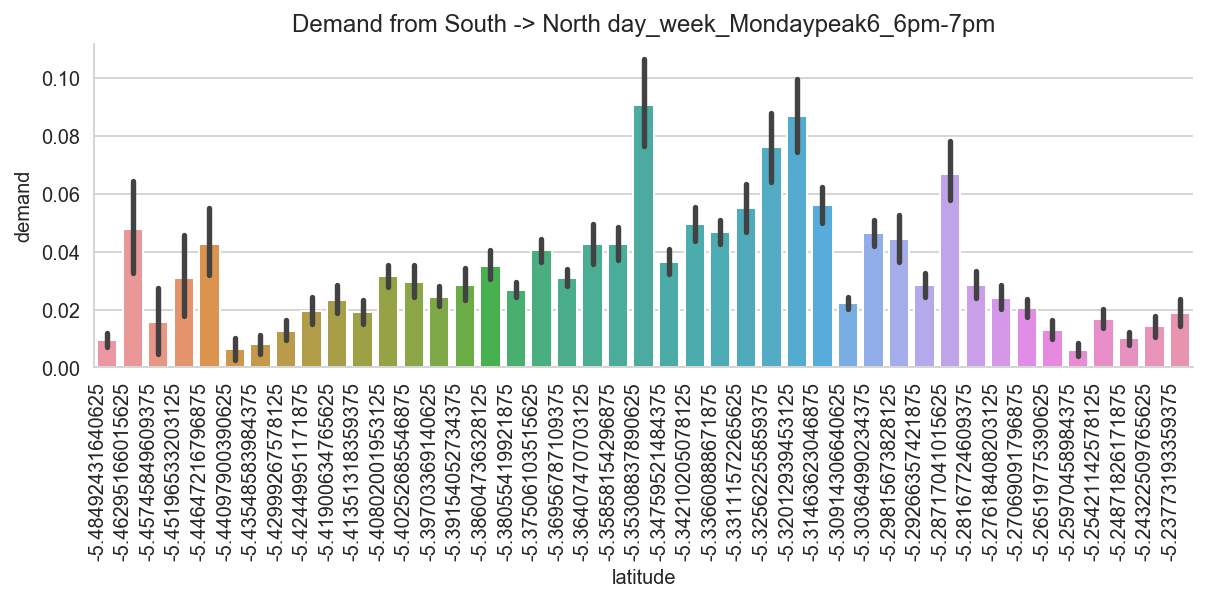

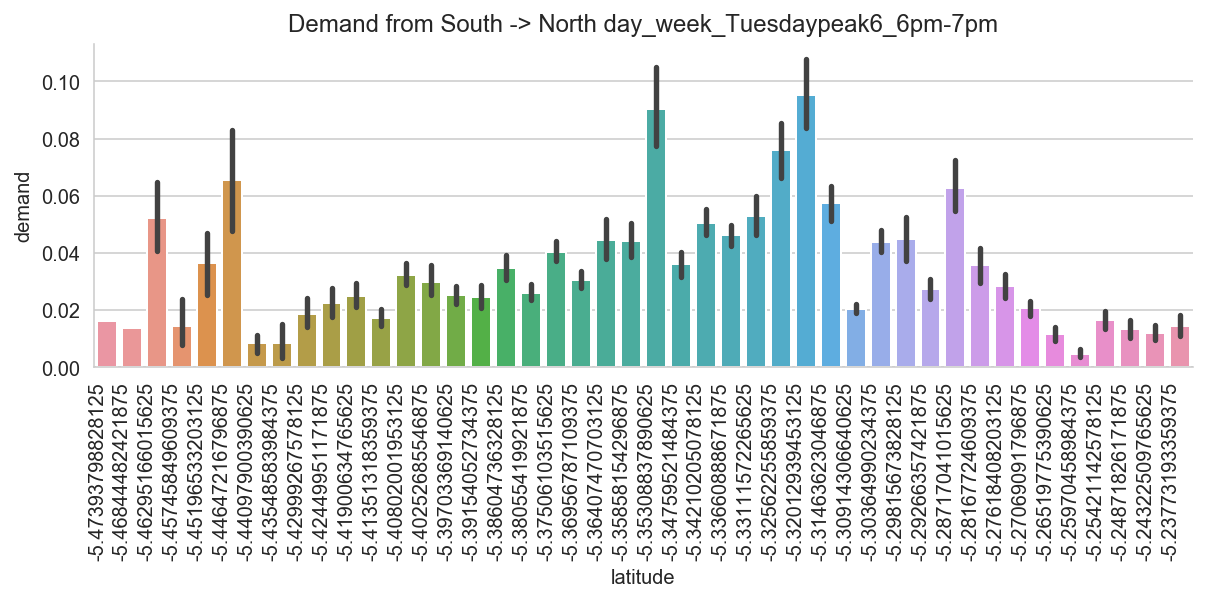

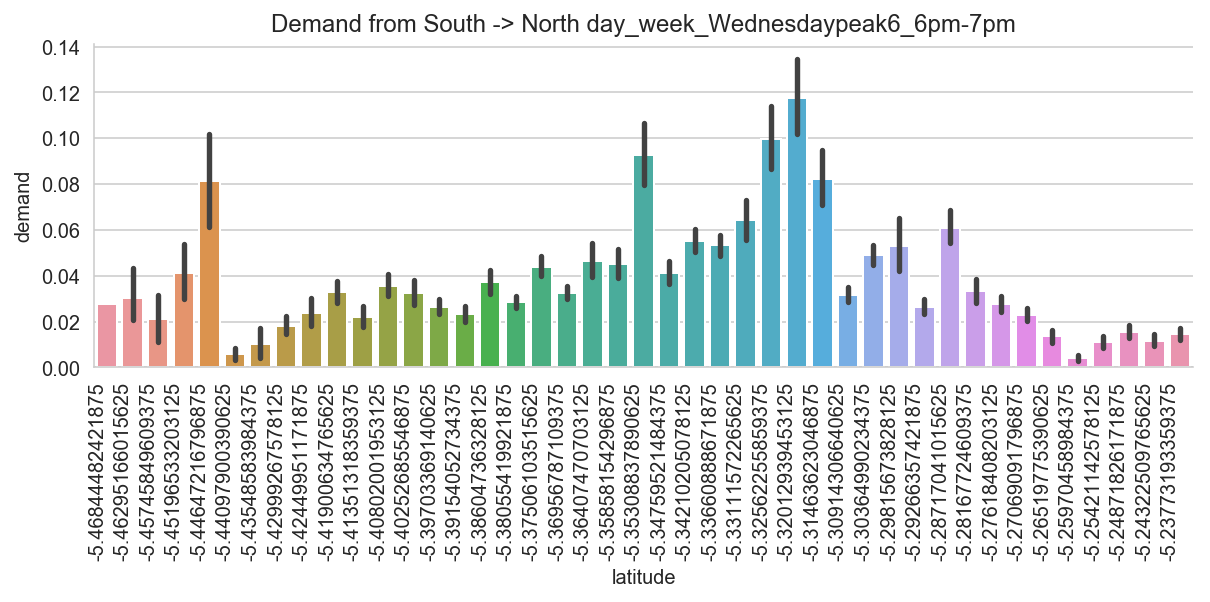

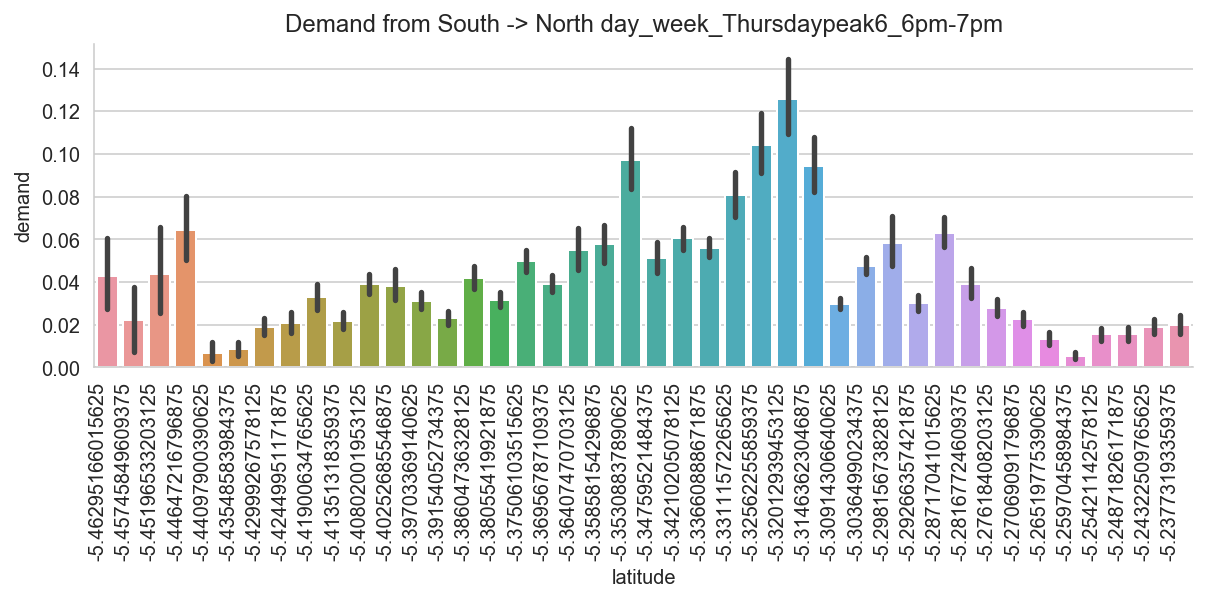

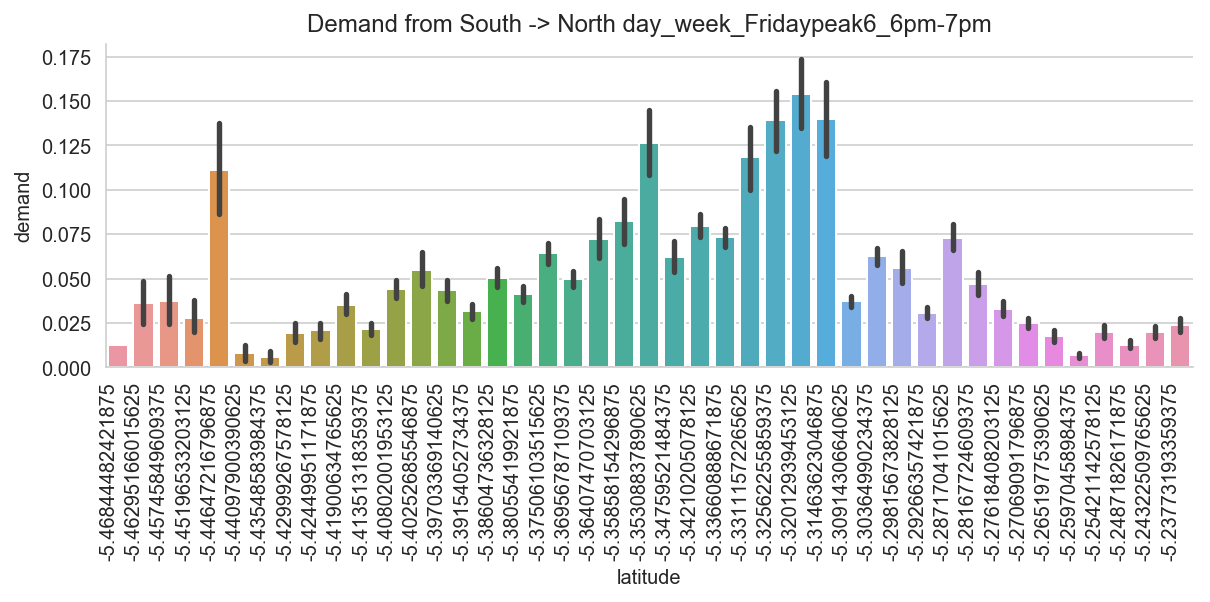

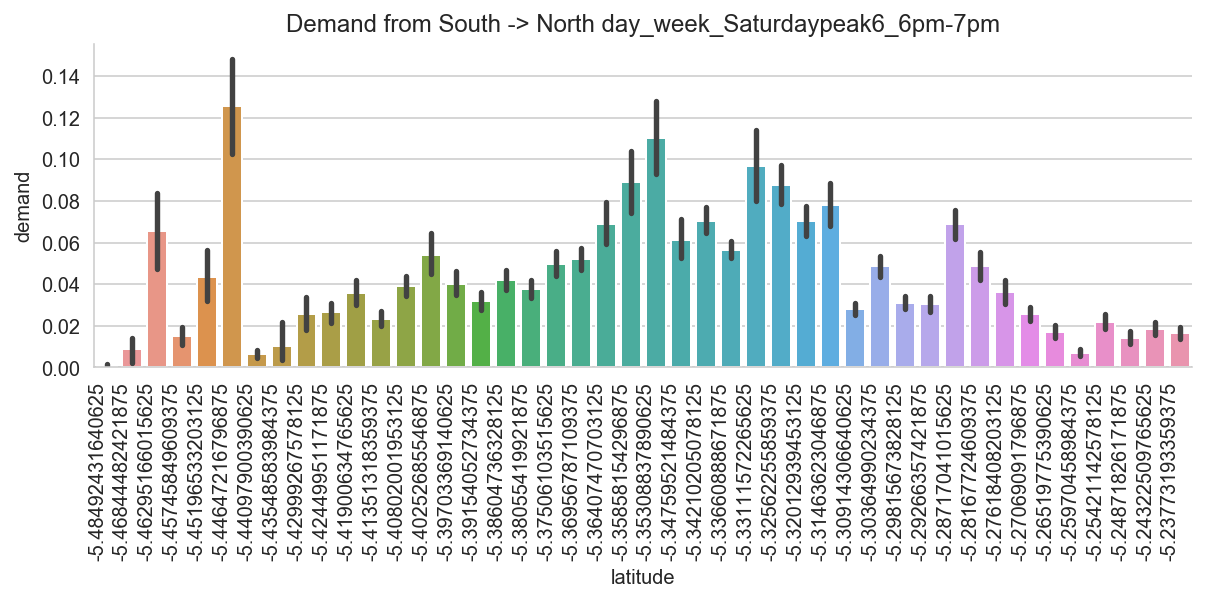

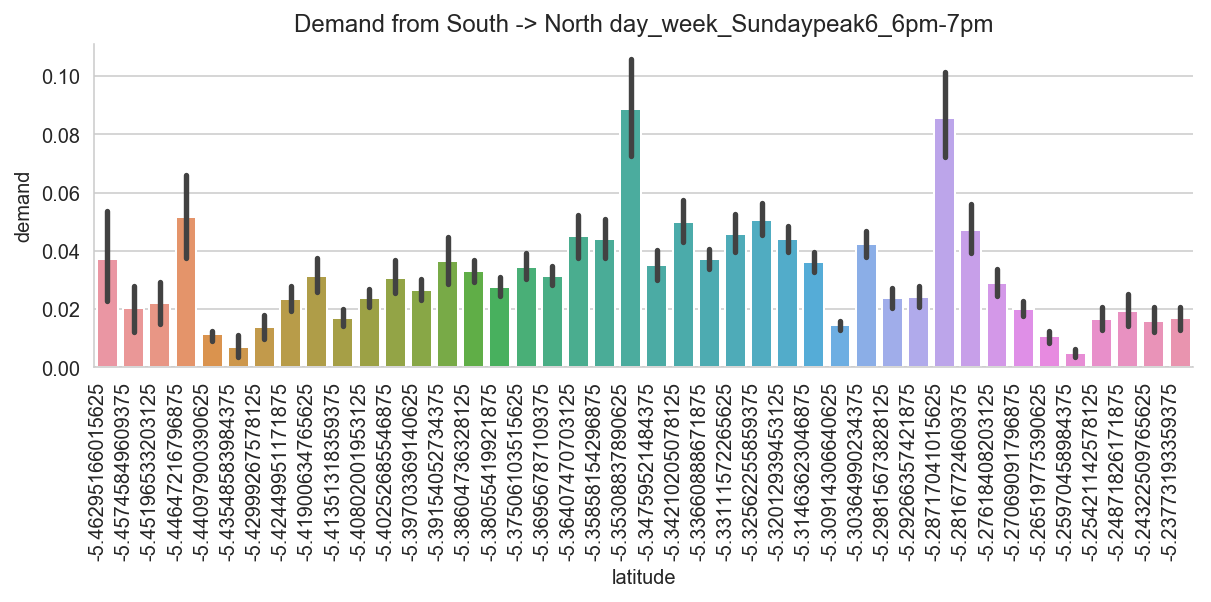

In [152]:
for period in day_week:
    sns.catplot(x='latitude', y='demand', height=3,
                   data=grab_dummified[grab_dummified['peak6_6pm-7pm']==1][grab_dummified[period]==1], kind='bar', aspect=3).set_xticklabels(rotation=90, horizontalalignment='right')
    plt.title('Demand from South -> North '+ str(period)+ 'peak6_6pm-7pm')

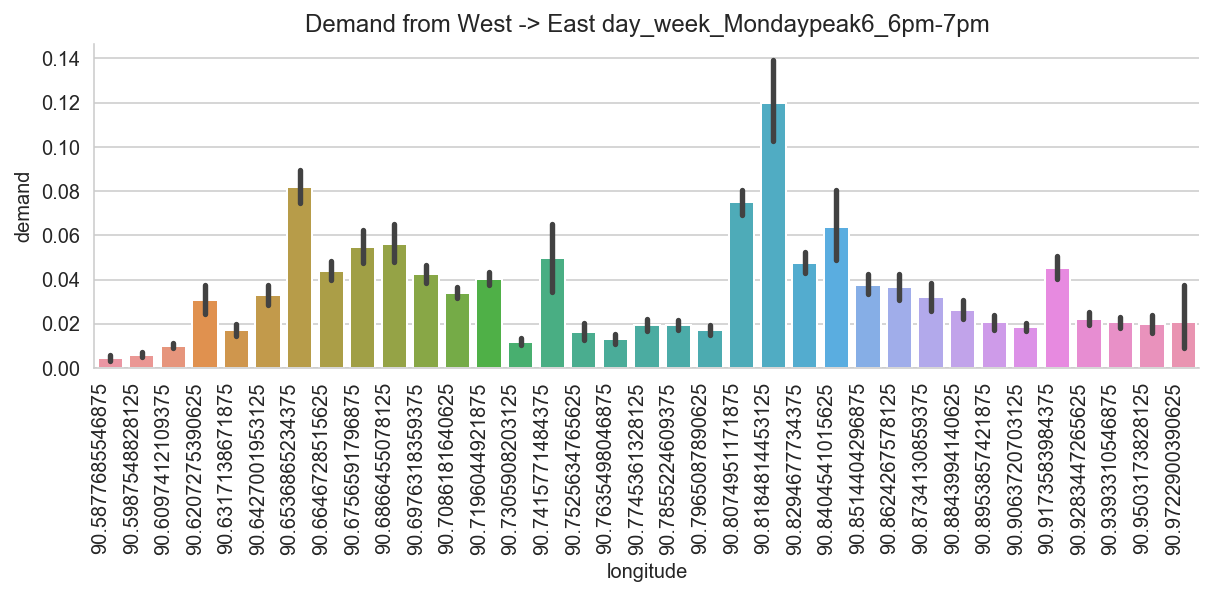

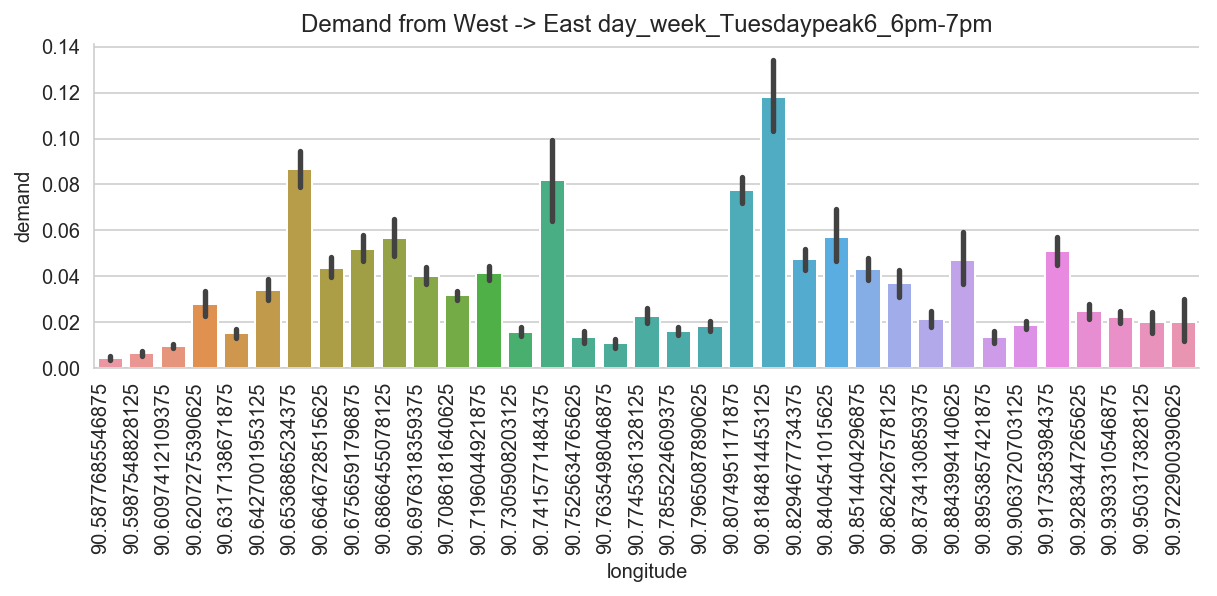

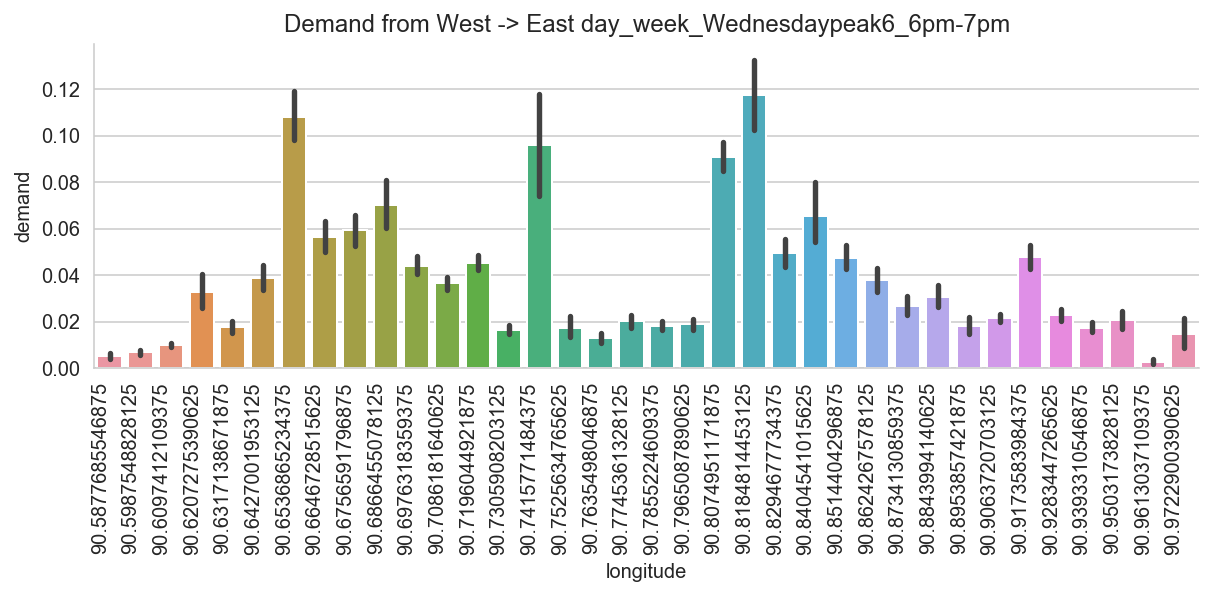

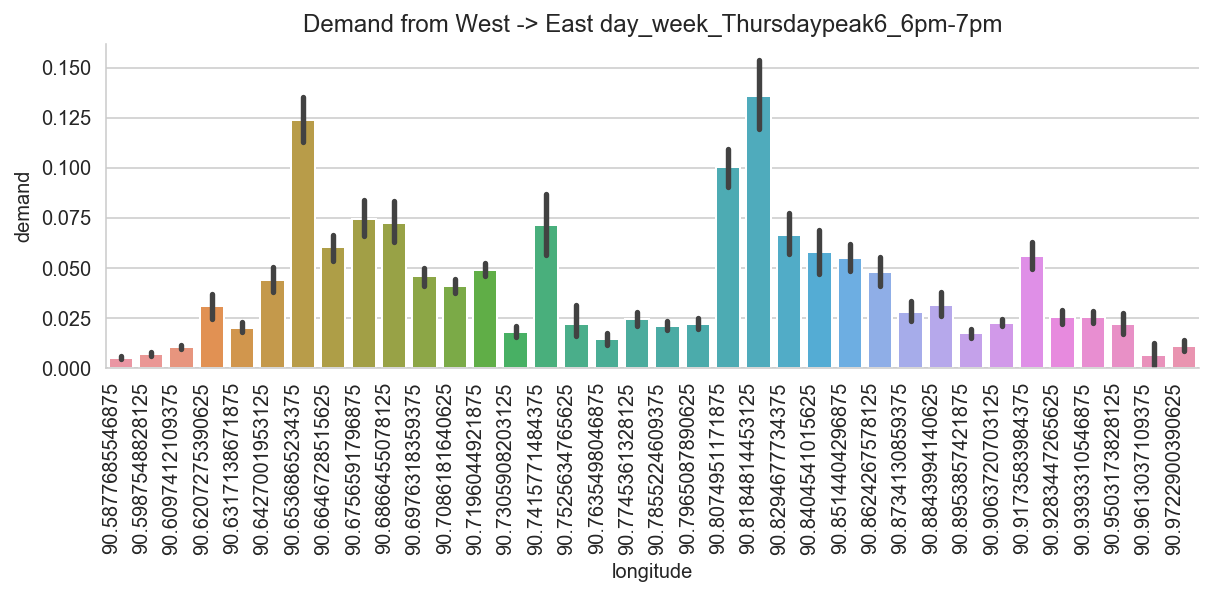

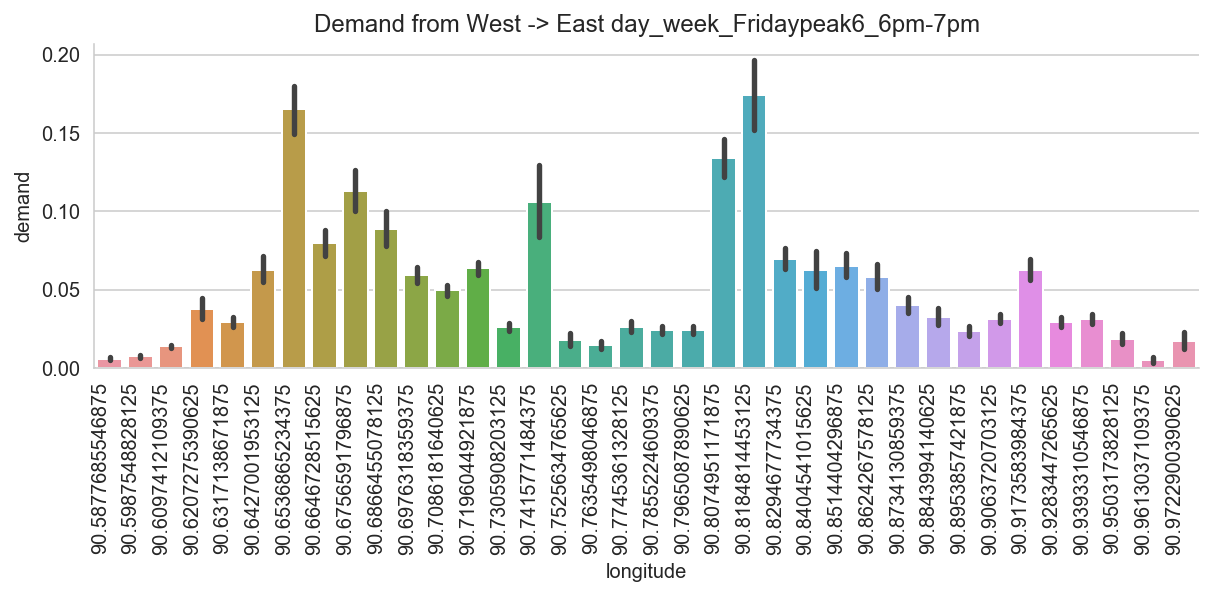

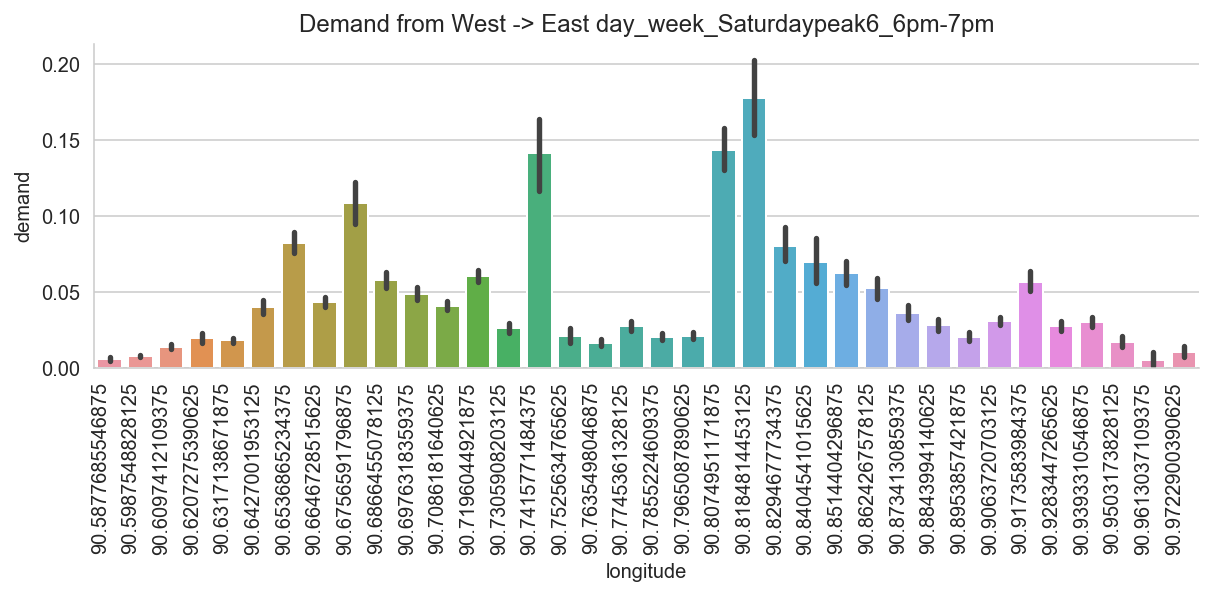

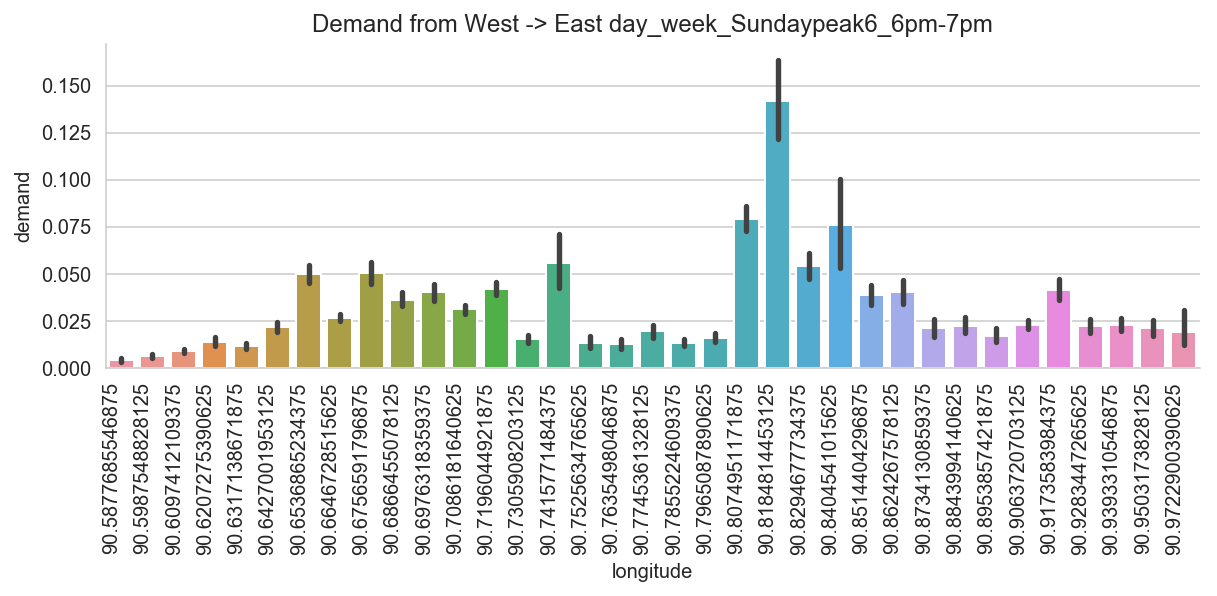

In [151]:
for period in day_week:
    sns.catplot(x='longitude', y='demand', height=3,
                   data=grab_dummified[grab_dummified['peak6_6pm-7pm']==1][grab_dummified[period]==1], kind='bar', aspect=3).set_xticklabels(rotation=90, horizontalalignment='right')
    plt.title('Demand from West -> East '+ str(period)+ 'peak6_6pm-7pm')

### Let's cut the map into 9 regions manually
- North
- North-East
- North-West
- South
- South-East
- South-West
- Central
- East
- West

In [61]:
# South
print(grab_dummified.latitude.min())
# North
print(grab_dummified.latitude.max())
# West
print(grab_dummified.longitude.min())
# East
print(grab_dummified.longitude.max())

-5.48492431640625
-5.23773193359375
90.5877685546875
90.9722900390625


In [62]:
min_lat = grab_dummified.latitude.min()
thirty_third_lat = ((grab_dummified.latitude.max()-grab_dummified.latitude.min())/3) + grab_dummified.latitude.min()
sixty_sixth_lat = ((grab_dummified.latitude.max()-grab_dummified.latitude.min())/3)*2 + grab_dummified.latitude.min()
max_lat = grab_dummified.latitude.max()

min_lon = grab_dummified.longitude.min()
thirty_third_lon = ((grab_dummified.longitude.max()-grab_dummified.longitude.min())/3) + grab_dummified.longitude.min()
sixty_sixth_lon = ((grab_dummified.longitude.max()-grab_dummified.longitude.min())/3)*2 + grab_dummified.longitude.min()
max_lon = grab_dummified.longitude.max()

In [63]:
print(min_lat)
print(thirty_third_lat)
print(sixty_sixth_lat)
print(max_lat)

-5.48492431640625
-5.40252685546875
-5.32012939453125
-5.23773193359375


In [64]:
print(min_lon)
print(thirty_third_lon)
print(sixty_sixth_lon)
print(max_lon)

90.5877685546875
90.7159423828125
90.8441162109375
90.9722900390625


In [65]:
lat_region = []
lon_region = []

for lat in grab_dummified['latitude'].tolist():
    if lat>=min_lat and lat<thirty_third_lat:
        lat_region.append('South')
    elif lat>=thirty_third_lat and lat<sixty_sixth_lat:
        lat_region.append('Central')
    elif lat >=sixty_sixth_lat and lat <=max_lat:
        lat_region.append('North')
    else:
        print(error)
        
for lon in grab_dummified['longitude'].tolist():
    if lon>=min_lon and lon<thirty_third_lon:
        lon_region.append('West')
    elif lon>=thirty_third_lon and lon<sixty_sixth_lon:
        lon_region.append('Central')
    elif lon >=sixty_sixth_lon and lon <=max_lon:
        lon_region.append('East')
    else:
        print(error)     

In [66]:
region_lat_lon = pd.DataFrame(data=None, index=None, columns=None, dtype=None, copy=False)
region_lat_lon['lat_region'] = lat_region
region_lat_lon['lon_region'] = lon_region
region_lat_lon['region_lat_lon'] = region_lat_lon['lat_region'] +'-' + region_lat_lon['lon_region']
region_lat_lon.replace('Central-Central', 'Central', inplace=True)
region_lat_lon.replace('Central-East', 'East', inplace=True)
region_lat_lon.replace('Central-West', 'West', inplace=True)
region_lat_lon.replace('North-Central', 'North', inplace=True)
region_lat_lon.replace('South-Central', 'South', inplace=True)

In [67]:
region_lat_lon.region_lat_lon.unique()

array(['Central', 'North', 'West', 'South-West', 'North-East', 'East',
       'North-West', 'South-East', 'South'], dtype=object)

In [68]:
region_lat_lon.shape

(4206321, 3)

In [69]:
grab_dummified.shape

(4206321, 119)

In [70]:
grab_dummified['region'] = region_lat_lon['region_lat_lon']

In [71]:
grab_dummified.shape

(4206321, 120)

In [72]:
grab_dummified.head()

day    demand  latitude  longitude  weekday  midnight_1am-6am  \
3849049   56  0.020689 -5.369568  90.763550        1                 0   
902676    40  0.008320 -5.281677  90.818481        0                 0   
1047754   29  0.229908 -5.375061  90.708618        1                 0   
4107759   31  0.088888 -5.457458  90.697632        1                 0   
95122     43  0.054890 -5.281677  90.884399        1                 0   

         peak1_6am-7am  peak2_7am-8am  peak3_8am-9am  peak4_9am-10am  \
3849049              0              0              0               0   
902676               0              0              0               0   
1047754              0              0              0               0   
4107759              0              0              0               0   
95122                0              0              0               0   

            ...      timestamp_9:30  timestamp_9:45  day_week_Friday  \
3849049     ...                   0               0                0   
902676      ...                   0               0                0   
1047754     ...                   0               0                0   
4107759     ...                   0               0                0   
95122       ...                   0               0                0   

         day_week_Monday  day_week_Saturday  day_week_Sunday  \
3849049                1                  0                0   
902676                 0                  1                0   
1047754                0                  0                0   
4107759                0                  0                0   
95122                  0                  0                0   

         day_week_Thursday  day_week_Tuesday  day_week_Wednesday      region  
3849049                  0                 0                   0       North  
902676                   0                 0                   0  South-East  
1047754                  0                 1                   0     Central  
4107759                  1                 0                   0     Central  
95122                    0                 1                   0  North-West  

[5 rows x 120 columns]

In [73]:
grab_dummified = pd.get_dummies(grab_dummified)

In [74]:
grab_dummified.head()

day    demand  latitude  longitude  weekday  midnight_1am-6am  \
3849049   56  0.020689 -5.369568  90.763550        1                 0   
902676    40  0.008320 -5.281677  90.818481        0                 0   
1047754   29  0.229908 -5.375061  90.708618        1                 0   
4107759   31  0.088888 -5.457458  90.697632        1                 0   
95122     43  0.054890 -5.281677  90.884399        1                 0   

         peak1_6am-7am  peak2_7am-8am  peak3_8am-9am  peak4_9am-10am  \
3849049              0              0              0               0   
902676               0              0              0               0   
1047754              0              0              0               0   
4107759              0              0              0               0   
95122                0              0              0               0   

            ...       day_week_Wednesday  region_Central  region_East  \
3849049     ...                        0               0            0   
902676      ...                        0               0            0   
1047754     ...                        0               1            0   
4107759     ...                        0               1            0   
95122       ...                        0               0            0   

         region_North  region_North-East  region_North-West  region_South  \
3849049             1                  0                  0             0   
902676              0                  0                  0             0   
1047754             0                  0                  0             0   
4107759             0                  0                  0             0   
95122               0                  0                  1             0   

         region_South-East  region_South-West  region_West  
3849049                  0                  0            0  
902676                   1                  0            0  
1047754                  0                  0            0  
4107759                  0                  0            0  
95122                    0                  0            0  

[5 rows x 128 columns]

## Now that we are done with our first stage of feature engineering, let's start with the Modeling Phase

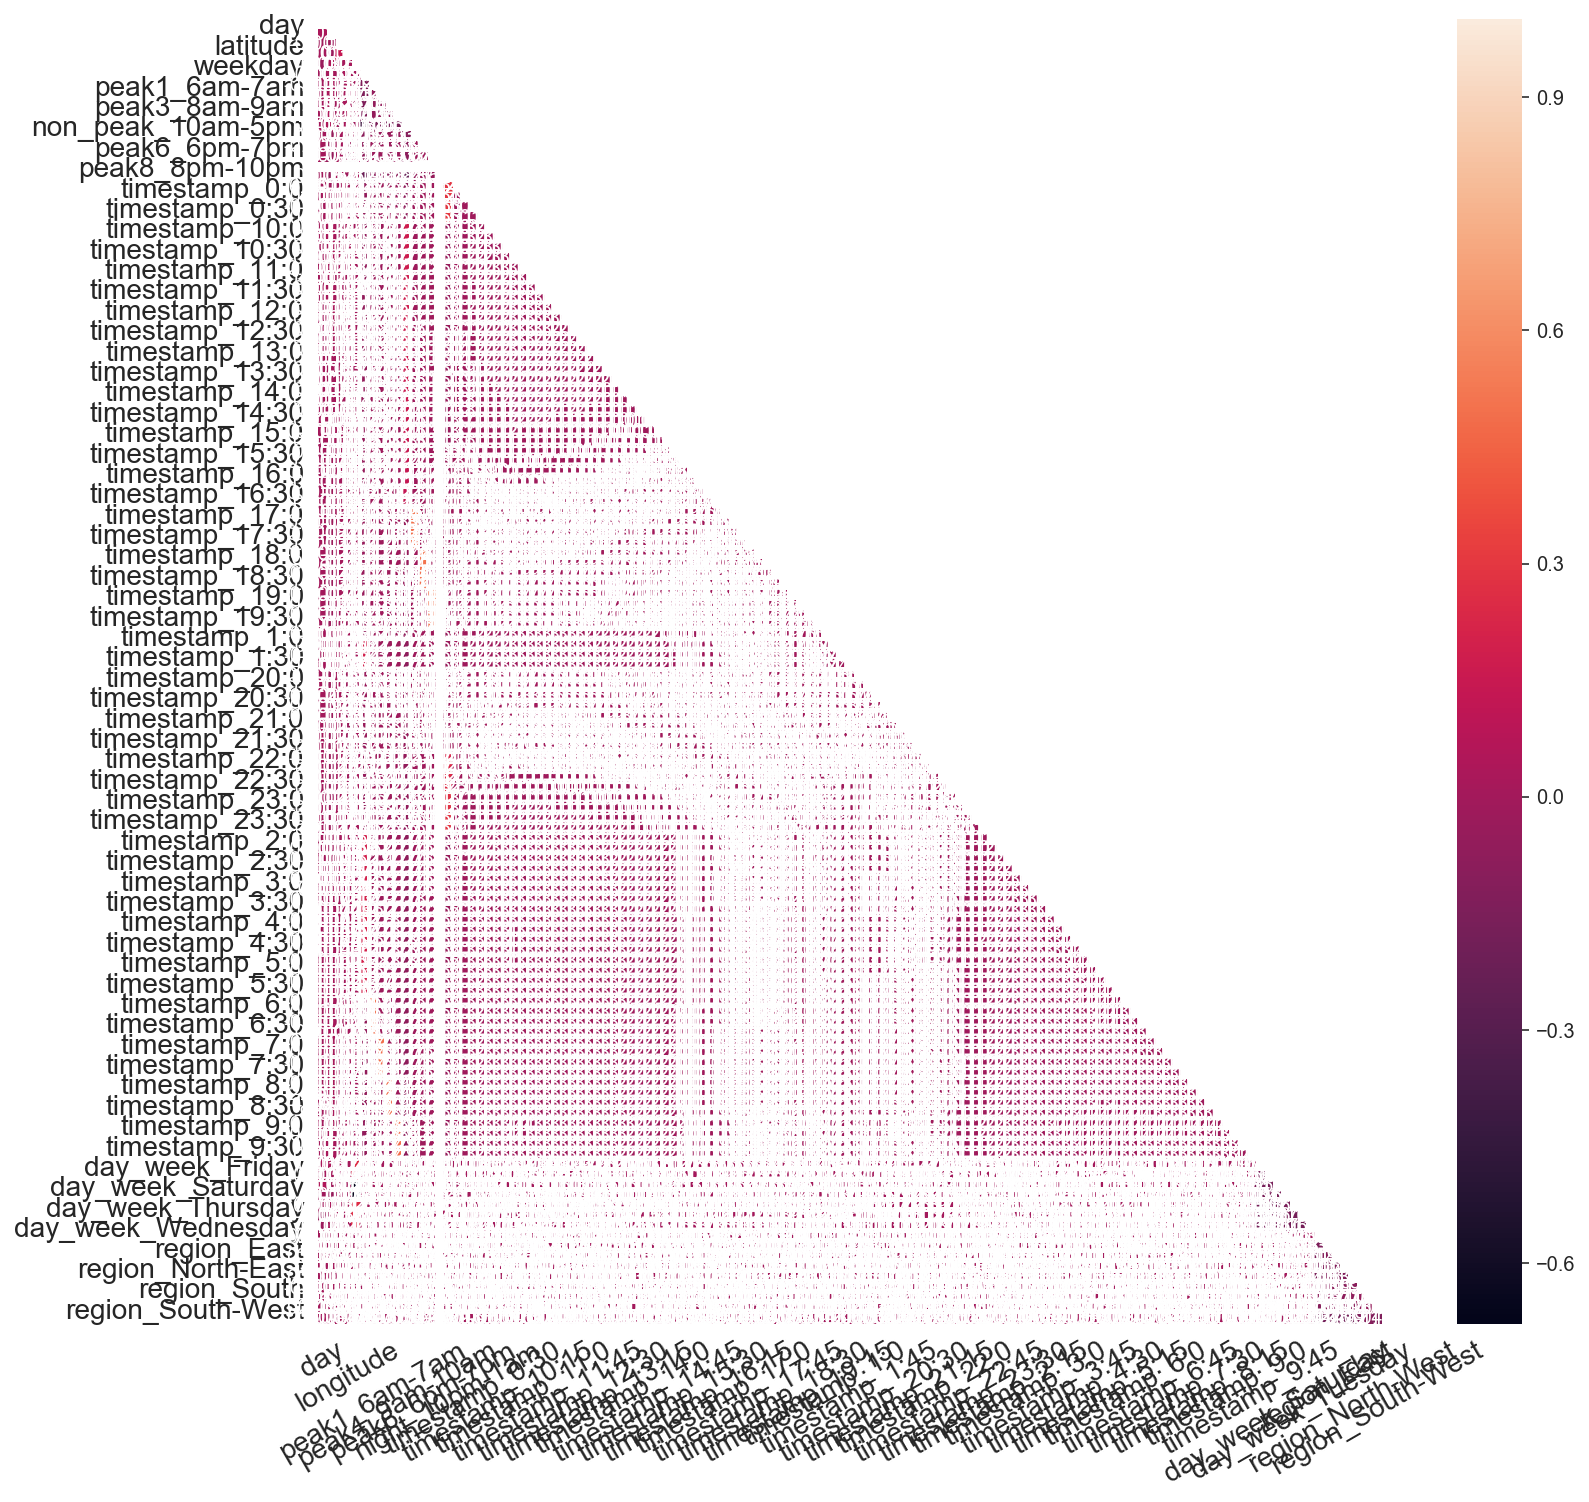

In [225]:
correlation_heat_map(grab_dummified)

In [75]:
corrs = grab_dummified.corr().sort_values('demand', ascending = False)
corrs['demand'].head(10)

demand               1.000000
non_peak_10am-5pm    0.046285
weekday              0.044979
peak4_9am-10am       0.043393
peak3_8am-9am        0.032886
day_week_Friday      0.031415
timestamp_10:0       0.023925
peak2_7am-8am        0.023829
day                  0.023643
timestamp_10:30      0.023482
Name: demand, dtype: float64

In [76]:
corrs['demand'].tail(10)

timestamp_21:45   -0.025527
timestamp_20:30   -0.025805
timestamp_20:45   -0.026328
longitude         -0.032438
peak5_5pm-6pm     -0.043914
day_week_Sunday   -0.044473
peak6_6pm-7pm     -0.047140
peak7_7pm-8pm     -0.048849
night_10pm-1am    -0.061775
peak8_8pm-10pm    -0.072986
Name: demand, dtype: float64

### Train-Test-Split

In [77]:
grab_dummified.shape

(4206321, 128)

In [78]:
# Let's Create training data with pre-2010 data 
X_train = grab_dummified[grab_dummified['day']<=50].drop(['demand','day'],axis =1).copy()
y_train = grab_dummified[grab_dummified['day']<=50].drop(['day'],axis =1)['demand'].copy()

# And testing data with 2010 data
X_test = grab_dummified[grab_dummified['day']>50].drop(['demand','day'],axis =1).copy()
y_test = grab_dummified[grab_dummified['day']>50].drop(['day'],axis =1)['demand'].copy()

In [79]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3422091, 126)
(3422091,)
(784230, 126)
(784230,)


In [80]:
X_train.head()

latitude  longitude  weekday  midnight_1am-6am  peak1_6am-7am  \
902676  -5.281677  90.818481        0                 0              0   
1047754 -5.375061  90.708618        1                 0              0   
4107759 -5.457458  90.697632        1                 0              0   
95122   -5.281677  90.884399        1                 0              0   
3076413 -5.408020  90.675659        0                 0              0   

         peak2_7am-8am  peak3_8am-9am  peak4_9am-10am  non_peak_10am-5pm  \
902676               0              0               0                  0   
1047754              0              0               0                  0   
4107759              0              0               0                  0   
95122                0              0               0                  0   
3076413              0              0               0                  0   

         peak5_5pm-6pm     ...       day_week_Wednesday  region_Central  \
902676               0     ...                        0               0   
1047754              0     ...                        0               1   
4107759              0     ...                        0               1   
95122                0     ...                        0               0   
3076413              0     ...                        0               0   

         region_East  region_North  region_North-East  region_North-West  \
902676             0             0                  0                  0   
1047754            0             0                  0                  0   
4107759            0             0                  0                  0   
95122              0             0                  0                  1   
3076413            0             0                  0                  0   

         region_South  region_South-East  region_South-West  region_West  
902676              0                  1                  0            0  
1047754             0                  0                  0            0  
4107759             0                  0                  0            0  
95122               0                  0                  0            0  
3076413             0                  1                  0            0  

[5 rows x 126 columns]

## Normalization

In [82]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
Xn_train = mms.fit_transform(X_train)
Xn_test = mms.transform(X_test)

In [83]:
Xn_train.shape

(3422091, 126)

In [261]:
from sklearn.linear_model import LinearRegression

cols = list(X_train.columns)

from sklearn.feature_selection import RFECV
lr = LinearRegression()

selector = RFECV(lr, step=1, cv=10)
selector = selector.fit(Xn_train, y_train)

rfecv_predictors = np.array(cols)[selector.support_]

print(rfecv_predictors)
print(selector.support_)
print(selector.ranking_)

['timestamp_20:15' 'timestamp_20:45']
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]
[125 124  14  34  32  31  42   9  33  22  17  41   8  36  56  54  53  52
 118 116 119 117 115 114 113 112 111 110 109 108 107 106 104 103 105 102
 101 100  99  98  97  96  95  94  93  92  23  24

## Only 2 features are eliminated using RFECV. 
## I have decided not remove any features because 2 features are insignificant when you are talking about 126 initial features.

In [265]:
from sklearn.model_selection import cross_val_score

lr = LinearRegression()

r2 = cross_val_score(lr, Xn_train, y_train, cv=10)

print(r2)
print('Mean CV-R2: {} (std {})'.format(round(np.mean(r2),4), round(np.std(r2),3)))

[-5.08110759e+23 -1.66152921e+21 -1.64405232e+22 -2.99231880e+22
 -7.51561993e+22 -5.88505701e+21 -1.30374774e+22 -2.80605638e+21
 -3.81933053e+23 -2.80131104e+23]
Mean CV-R2: -1.3150849463939532e+23 (std 1.7793464551006338e+23)


In [85]:
from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor(n_estimators = 20, random_state = 42)

r2 = cross_val_score(rf, Xn_train, y_train, cv=5)

print(r2)
print('Mean CV-R2: {} (std {})'.format(round(np.mean(r2),4), round(np.std(r2),3)))

### Regression clearly does not work because of seasonality.

#### - Next, I will move on to tackle this challenge using Time Series Modeling approach
#### - Recall that we need to predict T+15mins and T+75mins
#### - This means that we need our data to be ordered in time and equal spacing, in our case we are looking at 15 minutes interval
#### - We also need to remove Trends and Seasonality with a Difference Transform

# Let's restart the process and perform Time Series 

In [88]:
grab_train = pd.read_csv('./training.csv')

In [90]:
grab_train['latitude'] = grab_train['geohash6'].map(geohash_latdict)
grab_train['longitude'] = grab_train['geohash6'].map(geohash_londict)

In [91]:
grab_train.head()

geohash6  day timestamp    demand  latitude  longitude
0   qp03wc   18      20:0  0.020072 -5.353088  90.653687
1   qp03pn   10     14:30  0.024721 -5.413513  90.664673
2   qp09sw    9      6:15  0.102821 -5.325623  90.906372
3   qp0991   32       5:0  0.088755 -5.353088  90.752563
4   qp090q   15       4:0  0.074468 -5.413513  90.719604

## Let's see if our dataset consist of fixed intervals for timestamp

In [93]:
grab_train.geohash6.nunique()

1329

In [94]:
grab_train.shape

(4206321, 6)

#### There are 1329 unique locations, 61 days.
#### There should be 96(4x24hours) time periods if we are talking about 15minutes interval time stamps.
#### Thus, there should be 7,782,624 rows (1329x96x61)
#### .
#### However, there are only 4,206,321 rows in the dataset provided.
#### This means that the dataset is likely incomplete as the demand is not provided for ALL timestamps(15 mins) in this 61 days timeframe.

# To be continued...